## Predicine/Yale Triple Negative Breast Cancer collaboration

BEACON probes to be designed from Yale's prevous WGS tumor and normnal fastq files.
Data from prev published manuscript.

In [8]:
# install.packages('tidyverse')
# BiocManager::install("VariantAnnotation")
# install.packages('readxl')
# install.packages('eulerr')
# BiocManager::install('maftools')
# BiocManager::install('ComplexHeatmap')
# install.packages('conflicted')


The downloaded binary packages are in
	/var/folders/17/10yrd_j92yl57zwbb733lc7m0000gp/T//RtmpqRuZud/downloaded_packages


In [352]:
library(tidyverse)
library(readxl)
#library(VariantAnnotation)
library(ComplexHeatmap)
library(conflicted)
conflicts_prefer(dplyr::select, dplyr::rename, dplyr::filter)
#file.sources = list.files("~/Desktop/puffin/R/", pattern="*.R")
#funcs = lapply(paste0("~/Desktop/puffin/R/",file.sources), source, .GlobalEnv)

Sys.Date()
sessionInfo()

[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::select over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::rename over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer dplyr::filter over any other package.


[1] "2023-07-30"

R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gridExtra_2.3          GenomicFeatures_1.52.1 AnnotationDbi_1.62.2  
 [4] Biobase_2.60.0         ggfortify_0.4.16       GenomicRanges_1.52.0  
 [7] GenomeInfoDb_1.36.1    IRanges_2.34.1         S4Vectors_0.38.1      
[10] BiocGenerics_0.46.0    maftools_2.16.0        eulerr_7.0.0          
[13] RColorBrewer_1.1-3     glue_1.6.2             conflicted_1.2.0      
[16] ComplexHe

In [3]:
# files stored at: bgould@bluebird ssh bgould@10.10.0.9
    #  /prednet/data02/ProjectRawData/Yale/PRDC-YALE-TNBC-22001
# probe design see:
# /home/pdu/Projects/OtherAnalysis/Yale_MRD_BC/WES_baselines/Yale_MRD_baseline_analysis.R
# /home/pdu/Projects/OtherAnalysis/Yale_MRD_BC/WES_baselines/Personalized

In [ ]:
files.info = read_excel("./PRDC-YALE-TNBC-22001_WES_sampleinfo.xlsx", sheet="Sample_files")
names(files.info) <- make.names(names(files.info))

df_files.info = files.info %>% separate(File.name, c("PatientID","SampleType","Lane","R1.R2","file.ext"))

summary = df_files.info %>% group_by(PatientID, SampleType) %>% summarize(n_R1_files=sum(R1.R2=="R1"),
                                                                          n_R2_files=sum(R1.R2=="R2")) %>%
        mutate("PatientID.short"=sapply(PatientID, function(x) str_sub(x, 1, 6)))

stopifnot(sum(summary$n_R1_files) + sum(summary$n_R2_files) == nrow(files.info))
summary

print(sprintf("Patients: %s", length(unique(summary$PatientID.short))))

In [12]:
## count snps
# while read -r line; do source count_variants.sh $line; done < ../yale_patients.txt
# add PO sample filepaths and rerun
# for p in MD0004 MD0013 MD0014 MD0016; do source count_variants.sh $p ;done

df_counts = read.csv("./YALE_data/variant_calls/yale_snp_counts.txt", as.is=T, header=F)
df_files = df_counts[seq(1,nrow(df_counts),4),]
df_total = df_counts[seq(2,nrow(df_counts),4),]
df_filtered = df_counts[seq(3,nrow(df_counts),4),]
df_snvs = df_counts[seq(4,nrow(df_counts),4),]

df_counts = as.data.frame(cbind(df_files, df_total, df_filtered, df_snvs)) %>% filter(df_total!=0)

names(df_counts) <- c("PatientID","total_SNVandIndel","total_filtered_SNVs","SNVs_MAF>0.05_DP>9")

write.csv(df_counts, "./YALE_data/variant_calls/YALE_TNBC_SNV_counts.csv", row.names=F, quote=F)

In [47]:
patients = read.csv("YALE_data/yale_patients.txt", header=F)
source("~/Desktop/puffin/R/helper_functions.R")

In [353]:
# extract and plot allele frequencies ## rerun post-file corrections
#patients_ = c("MD0001")
patients_ = unique(clin.data$PatientID) # see below
af.list=list()
for (patient in patients_){
#print(patient)
#infile = paste0("./YALE_data/variant_calls/",patient,"_filtered_SNVs.recode.vcf")
    if (patient %in% c("MD0004","MD0014","MD0013","MD0016")){
        next
    }
    infile = paste0("./YALE_WES_data/variant_calls/unfiltered_vcfs/",patient,"_wesTumor_Vs_",patient,"_wesNormal_filtered_vep_anno.vcf")
    #print(head(read.table(infile, comment="#", sep="\t", header=F)))
    #stop()
    df_snps <- read.table(infile, comment = '#', sep="\t", header=F) %>% 
                #mutate("Filters"=(str_split(V7,";"))) %>%
                #filter(Filters %in% c("PASS","germline")) %>%
                filter(grepl("pass|germline", V7, ignore.case=T)) %>%
                mutate("CHROM"=paste0("chr",V1), "start"=V2, "end"=V2) %>%
                mutate("SNV"=paste0(CHROM,":",start), "PatientID"=patient, "Filters"=V7) %>%
                select(CHROM, start, end, PatientID, SNV, V10, V11, Filters) %>% 
                separate(V10, into=c("GT.n","AD.n","AF.n","DP.n"), extra="drop", sep=":") %>% # NORMAL
                separate(AD.n, into=c("AD.nRef","AD.nAlt"), sep=",") %>% 
                mutate("N.MAF"=(as.numeric(AD.nAlt)/as.numeric(DP.n))*100,
                       "DP.n"=as.numeric(DP.n)) %>%
                separate(V11, into=c("GT.t","AD.t","AF.t","DP.t"), extra="drop", sep=":") %>% # TUMOR
                separate(AD.t, into=c("AD.tRef","AD.tAlt"), sep=",") %>% 
                mutate("T.MAF"=(as.numeric(AD.tAlt)/as.numeric(DP.t))*100,
                       "DP.t"=as.numeric(DP.t)) %>%
                mutate("is.germ"=grepl("germline", Filters))
    #print(nrow(df_snps))
    af.list[[patient]] = df_snps %>% #select(PatientID, SNV, N.MAF, T.MAF) %>%
            mutate(Concordant=(N.MAF!=0 & T.MAF!=0))
}

af.table = do.call(rbind, af.list)

head(af.table)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 1679 rows [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 29, 30, 31, 32, 33, 34, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1679 rows [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 29, 30, 31, 32, 33, 34, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1604 rows [1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 30, 31, 34, 35, 36, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1604 rows [1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 30, 31, 34, 35, 36, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 2218 rows [7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 2218 rows [7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, ...].”
Warning message:
“Expected 2 pieces.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 4507 rows [1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 25, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1714 rows [2, 3, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 35, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1714 rows [2, 3, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 35, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 4607 rows [3, 6, 7, 8, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 30, 31, 32, 33, 39, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 4607 rows [3, 6, 7, 8, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 30, 31, 32, 33, 39, ...].”
Warning message:
“Expected 2 pieces. Additional pieces discarded in 1769 rows [1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 21, 23, 31, 33, 35, 36, ...].”
Warning message:
“Expected 2 piec

,CHROM,start,end,PatientID,SNV,GT.n,AD.nRef,AD.nAlt,AF.n,DP.n,GT.t,AD.tRef,AD.tAlt,AF.t,DP.t,Filters,N.MAF,T.MAF,is.germ,Concordant
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
MD0001.1,chr1,1190990,1190990,MD0001,chr1:1190990,0/0,8,0,0.100,8,0/1,20,28,0.592,48,germline,0.00000,58.333333,TRUE,FALSE
MD0001.2,chr1,1639062,1639062,MD0001,chr1:1639062,0/0,14,0,0.063,14,0/1,86,33,0.285,119,germline;panel_of_normals,0.00000,27.731092,TRUE,FALSE
MD0001.3,chr1,3548448,3548448,MD0001,chr1:3548448,0/0,18,11,"0.287,0.121",33,0/1/2,169,83,"0.262,0.113",283,clustered_events;germline;multiallelic;normal_artifact,33.33333,29.328622,TRUE,TRUE
MD0001.4,chr1,3753032,3753032,MD0001,chr1:3753032,0/0,2,0,"0.060,0.100,0.423",6,0/1/2/3,19,4,"0.086,0.105,0.304",41,germline;multiallelic;normal_artifact,0.00000,9.756098,TRUE,FALSE
MD0001.5,chr1,3788978,3788978,MD0001,chr1:3788978,0/0,3,2,"0.231,0.345,0.079",8,0/1/2/3,39,9,"0.137,0.175,0.061",60,germline;multiallelic;normal_artifact;slippage,25.00000,15.000000,TRUE,TRUE
MD0001.6,chr1,6291918,6291918,MD0001,chr1:6291918,0/0,8,0,"0.068,0.069,0.151",9,0/1/2/3,50,4,"0.058,0.227,0.095",80,germline;multiallelic,0.00000,5.000000,TRUE,FALSE


In [168]:
library(GenomicFeatures)
library(GenomicRanges)

white.list.gr = readRDS("~/Desktop/Translational_Science/code_versions/whitelist_200822.rds")

wes.gr = makeGRangesFromDataFrame(af.table, keep.extra.columns = TRUE)
length(wes.gr)

# Find overlaps and assign feature to regions
hits <- findOverlaps(query = wes.gr, subject = white.list.gr, ignore.strand = TRUE)
length(hits)
mcols(wes.gr)$white.list <- FALSE
mcols(wes.gr[queryHits(hits)])$white.list <- TRUE
sum(mcols(wes.gr)$white.list)

af.table.ann = data.frame(wes.gr)
head(af.table.ann)

[1] 141582

[1] 168

[1] 61

,seqnames,start,end,width,strand,PatientID,SNV,GT.n,AD.nRef,AD.nAlt,⋯,AD.tRef,AD.tAlt,AF.t,DP.t,Filters,N.MAF,T.MAF,is.germ,Concordant,white.list
,<fct>,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
1,chr1,1190990,1190990,1,*,MD0001,chr1:1190990,0/0,8,0,⋯,20,28,0.592,48,germline,0.00000,58.333333,TRUE,FALSE,FALSE
2,chr1,1639062,1639062,1,*,MD0001,chr1:1639062,0/0,14,0,⋯,86,33,0.285,119,germline;panel_of_normals,0.00000,27.731092,TRUE,FALSE,FALSE
3,chr1,3548448,3548448,1,*,MD0001,chr1:3548448,0/0,18,11,⋯,169,83,"0.262,0.113",283,clustered_events;germline;multiallelic;normal_artifact,33.33333,29.328622,TRUE,TRUE,FALSE
4,chr1,3753032,3753032,1,*,MD0001,chr1:3753032,0/0,2,0,⋯,19,4,"0.086,0.105,0.304",41,germline;multiallelic;normal_artifact,0.00000,9.756098,TRUE,FALSE,FALSE
5,chr1,3788978,3788978,1,*,MD0001,chr1:3788978,0/0,3,2,⋯,39,9,"0.137,0.175,0.061",60,germline;multiallelic;normal_artifact;slippage,25.00000,15.000000,TRUE,TRUE,FALSE
6,chr1,6291918,6291918,1,*,MD0001,chr1:6291918,0/0,8,0,⋯,50,4,"0.058,0.227,0.095",80,germline;multiallelic,0.00000,5.000000,TRUE,FALSE,FALSE


In [177]:
Color.str = "black"
log.axes = TRUE
color.by="white.list"
color.by.foreground.value = "TRUE"
fill.na = 0.1
pt.sz=10
patients_ = unique(clin.data$PatientID)

pdf("./YALE_WES_data/variant_calls/Yale_TNBC_SNV_MAF_scatters_unfiltered_whitelist_ann_06282023.pdf", onefile = TRUE)
for (patient in patients_){
    if (patient %in% c("MD0004","MD0014","MD0013","MD0016")){
        next
    }
    df_plot = af.table.ann %>% filter(PatientID==patient) 
    if (log.axes){
        #fill.na = round(0.5 * min(c(df_plot$T.MAF,df_plot$N.MAF)), 2)
        df_plot$N.MAF[df_plot$N.MAF==0] <- fill.na
        df_plot$T.MAF[df_plot$T.MAF==0] <- fill.na
      }
#print(head(df_plot))
gg <- ggplot(df_plot, aes_string(x="N.MAF", y="T.MAF", col=color.by)) +
      geom_point(aes(
        size=pt.sz, 
        alpha=0.5,
        shape=Concordant
      )) +
      scale_color_manual(values = c("FALSE"="darkturquoise","TRUE"="coral1")) +
      scale_shape_manual(values = c("TRUE"=19,"FALSE"=17)) +
      geom_abline(slope=1, intercept=c(0,0), linetype="dashed") +
      labs(x="Normal MAF (%)", y="Tumor MAF (%)", title=patient) +
      theme(text=element_text(size=20), legend.position="bottom", plot.title=element_text(size=20))
    if (!is.na(color.by.foreground.value)){
      color.by_ = df_plot[,color.by]
      df_plot = df_plot %>% mutate("Color"=color.by_)
      df = df_plot %>% filter(Color==color.by.foreground.value)
      if (nrow(df)!=0){
        print("coloring foreground")
        gg <- gg +
          geom_point(df, mapping=aes(size=pt.sz, alpha=0.5, shape=Concordant))
      }
    }
    if (log.axes){
      gg <- gg +
        scale_y_continuous(trans='log2', breaks=c(fill.na,0.1,0.5, 1.0, 5.0, 10.0, 25.0, 50.0,100)) +
        scale_x_continuous(trans='log2', breaks=c(fill.na,0.1,0.5, 1.0, 5.0, 10.0, 25.0, 50.0,100))
    }
    if (all(df_plot$N.MAF == fill.na)){
      gg <- gg + xlim(fill.na, max(df_plot$T.MAF))
    }
    if (all(df_plot$T.MAF == fill.na)){
      gg <- gg + ylim(fill.na, max(df_plot$N.MAF))
    }
    show(gg)
}
dev.off()

[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"
[1] "coloring foreground"


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


[1] "coloring foreground"


pdf 
  2

## SNP barcodes

In [116]:
df_codes = read.csv("../Translational_Science/Methods/SNP_sampleBC_5_190616_grch37_04262023.csv", as.is=T) %>%
    separate("VariantID", c("seqnames","start","end","ref","alt")) %>%
    mutate("seqnames"=gsub("chr","",seqnames), BC=paste0(seqnames,":",start)) #in order by number not position
#out.file = "../Translational_Science/Methods/SNP_sampleBC_5_190616_grch37_04262023.bed"
#out.file = "./Hang_germ_calls/SNP_sampleBC_5_190616_grch37_04262023.tsv"
#write.table(df_codes %>% dplyr::select(seqnames, start) %>% arrange(seqnames, start), out.file, 
#                sep="\t", row.names=F, col.names=F, quote=F)

# df_codes <- GRanges(df_codes)
# param <- ScanVcfParam(which=df_codes)

# test = GRanges(seqnames="1", ranges=IRanges(14673,14673))
# df_codes <- c(df_codes, test)
head(df_codes)


,Order,seqnames,start,end,ref,alt,SNP,SNP.AF,Gene,EXON,INTRON,Consequence,PredicineLite,DDR,BC
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>
1,1,13,32953388,32953388,T,C,rs4942486,0.511581,BRCA2,NA,21/27,intron_variant,TRUE,TRUE,13:32953388
2,2,10,89720907,89720907,T,G,rs555895,0.432508,PTEN,NA,8/8,intron_variant,TRUE,TRUE,10:89720907
3,3,12,133219831,133219831,T,C,rs5744944,0.605232,POLE,35/49,NA,synonymous_variant,TRUE,TRUE,12:133219831
4,4,14,105242966,105242966,T,C,rs2494735,0.596446,AKT1,NA,4/13,intron_variant,TRUE,TRUE,14:105242966
5,5,3,37048633,37048633,A,G,rs4234259,0.309305,MLH1,NA,5/18,intron_variant,TRUE,TRUE,3:37048633
6,6,2,47693959,47693959,G,A,rs3732183,0.483427,MSH2,NA,10/15,intron_variant,TRUE,TRUE,2:47693959


In [74]:
# input unfiltered SNP files
##filtering_status=Warning: unfiltered Mutect 2 calls.  Please run FilterMutectCalls to remove false positives.
##normal_sample=MD0013PO_wesNormal
##source=Mutect2
##tumor_sample=MD0013_wesTumor
##GATKCommandLine=<ID=Mutect2,CommandLine="Mutect2
##.      --reference /prednet/data03/DevHome/hdong/GATK_bundle/grch37/human_g1k_v37.fasta
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  MD0013PO_wesNormal      MD0013_wesTumor

# zipped <- bgzip("./Hang_realignment_results/MD0001_wesTumor.matched.gathered.vcf",
#                 "./Hang_realignment_results/MD0001_wesTumor.matched.gathered.vcf.zip")
#idx <- indexTabix("./Hang_realignment_results/MD0013_wesTumor.matched.gathered.vcf.gz", "vcf")
tab <- TabixFile("./Hang_realignment_results/MD0013_wesTumor.matched.gathered.vcf.gz")
vcf_rng <- readVcf(tab, param=df_codes)
# df_vcf = readVcf("./Hang_realignment_results/MD0001_wesTumor.matched.gathered.vcf", genome = "hg19", param = df_codes)

# Hang will rerun mutect2 for these sites only

In [ ]:
## extract snp barcode sites available from germline variant files
# commands.sh
#for file in /prednet/data03/DevHome/hdong/Analysis/WES_projects/Yale_project/all_run/vcf_with_germline_genotype/vcfs/*.vcf
#  do
#   PID="$(basename $file)"
#   echo $PID
#   bgzip -c $file > ${PID}.gz
#   tabix ${PID}.gz
#   bcftools filter -R ../SNP_sampleBC_5_190616_grch37_04262023.tsv ${PID}.gz > ${PID}_snpBC.vcf
#  done
# for file in *snpBC*
#   do
#    bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[%SAMPLE:%AF\t]\n' $file > ${file}.info
#   done

# cat *.info > all_barcode_data.tsv
# echo "done"

## from set of all unique sites present across cohort, missing sites within individuals should be called as 0/0 

df_bcs = read.csv("./Hang_germ_calls/all_barcode_data.tsv", sep="\t", header=F) 
names(df_bcs) <- c("chr","pos","ref","alt","norm","tumor","na")
df_bcs = df_bcs %>% mutate(BC=paste0(chr,":",pos))

df_bcs = rbind(df_bcs %>% select(-na, -tumor) %>% separate(norm, c("sample","AF"), sep=":"), 
               df_bcs %>% select(-na, -norm) %>% separate(tumor, c("sample","AF"), sep=":"))
bcs = data.frame(BC=unique(df_bcs$BC))
df_bcs = df_bcs %>% group_by(sample) %>% mutate(obs = seq(n())) %>% 
    ungroup() %>% complete(sample, BC) %>% mutate(AF=as.numeric(AF), AF=replace_na(AF,0.0))
df_bcs = df_bcs %>% mutate("call."=ifelse(AF>=0.7, 2, ifelse(0.2<=AF & AF<0.7, 1, 0))) %>%
                    mutate(BC=factor(BC, levels=df_codes$BC))

df_bcs.summary = df_bcs %>% group_by(sample) %>% arrange(BC) %>% summarize(snp.bc=gsub(",","",toString(call.))) %>% 
    mutate(snp.bc=gsub(" ","",snp.bc))

df_bcs.summary

In [115]:
# tree for baselines only
source("~/Desktop/puffin/R/Other_functions.R") 
# plotSampleRelationSNP_BC <- function(SNP_BC, SNP_BC2=NULL, suffix=NULL, plotCol='SNP_BC', labelCol='SampleID', mdsPlot=FALSE, title=NULL, ...)
pdf("./YALE-TNBC-_sampleRelation_baselines_06052023.pdf", width=20, height = 7)
plotSampleRelationSNP_BC(SNP_BC=df_bcs.summary, plotCol='snp.bc', labelCol='sample', mdsPlot=FALSE, 
                         title='Sample relations based on SNP barcodes')
dev.off()

pdf 
  2

In [126]:
# add MRD samples to the BC tree
bc_filter = which(df_codes$BC %in% bcs$BC) # probe set in wes file markers
subsetBC <- function(example.string){
    return(paste(unlist(strsplit(example.string, ''))[bc_filter], collapse = ''))
}

# second earlier falcon file from aborted run (?)
#mrd1 = read.csv("./mrd_results/2023-06-04T21_55_17.096996+00_00__230530_A01832_0149_BH7VHLDSX7__WOP00554_PRDC-YALE-TNBC-22001_combined_NGSQC_Summary_all.csv", skip=1, as.is=T)
mrd.data = read.csv("./mrd_results/2023-06-05T19_54_20.391353+00_00__230530_A01832_0149_BH7VHLDSX7__WOP00554_PRDC-YALE-TNBC-22001_combined_NGSQC_Summary_all.csv", 
                    skip=1, as.is=T) %>% filter(QC_Status != "Fail") %>% select(SampleID, SNP_BC)
mrd.data = mrd.data %>% mutate(snp.bc=gsub("'","",SNP_BC)) 
mrd.data$snp.bc <- as.character(lapply(mrd.data$snp.bc, subsetBC))
head(mrd.data %>% arrange(SampleID))
print(mrd.data[1,"snp.bc"])
stopifnot(length(mrd.data[1,"snp.bc"])==length(df_bcs.summary[1,"snp.bc"]))

,SampleID,SNP_BC,snp.bc
,<chr>,<chr>,<chr>
1,P228249A01,'21212110202200202111210110212101010',2121211002002112101100
2,P228251A01,'22010100011100102110211011212121121',2201010011002102110111
3,P228254A01,'20010211110010212020011011111211020',2001021110012000110110
4,P228255A01,'01122110100012010001001000110101110',0112211000210010010001
5,P228257A01,'10101200222020101121011022211011121',1010120020001110110221
6,P228258A01,'00201101012021200020212111201120021',0020110110100002121110


[1] "2121211002002112101100"


In [129]:
biolims.data = read_excel("./PRDC-YALE-TNBC-22001 Project Summary 20230519WM.xlsx", sheet="BioLIMS info")
names(biolims.data) <- make.names(names(biolims.data))

sample_to_pid = biolims.data$Patient.ID
names(sample_to_pid) <- biolims.data$Sample.ID

sample_to_extid = biolims.data$BarCode
names(sample_to_extid) <- biolims.data$Sample.ID

mrd.data = mrd.data %>% mutate(PatientID=recode(SampleID, !!!sample_to_pid),
                               sample=recode(SampleID, !!!sample_to_extid)) %>% arrange(PatientID)
head(mrd.data)

,SampleID,SNP_BC,snp.bc,PatientID,sample
,<chr>,<chr>,<chr>,<chr>,<chr>
1,P228249A01,'21212110202200202111210110212101010',2121211002002112101100,MD0003,MD0003_Post-NAC_P_1
2,P228251A01,'22010100011100102110211011212121121',2201010011002102110111,MD0005,MD0005_Post-NAC_P_1
3,P228254A01,'20010211110010212020011011111211020',2001021110012000110110,MD0013,MD0013_Post-NAC_P_1
4,P228255A01,'01122110100012010001001000110101110',0112211000210010010001,MD0014,MD0014_Post-NAC_P_1
5,P228257A01,'10101200222020101121011022211011121',1010120020001110110221,MD0016,MD0016_Post-NAC_P_1
6,P228258A01,'00201101012021200020212111201120021',0020110110100002121110,MD0017,MD0017_Post-NAC_P_1


In [131]:
all.data = rbind(mrd.data %>% select(sample, snp.bc),
                 df_bcs.summary)

pdf("./YALE-TNBC-_sampleRelation_06062023.pdf", width=20, height = 7)
plotSampleRelationSNP_BC(SNP_BC=all.data, plotCol='snp.bc', labelCol='sample', mdsPlot=FALSE, 
                         title='Sample relations based on SNP barcodes - MRD + Baselines')
dev.off()

pdf 
  2

In [38]:
## filtered WES variant calls for client
files = list.files("./PD_probe_design/", pattern="*_filtered.tsv") 
dfs = c()
for (file in files){
    pid = substring(file,1,nchar(file)-4)
    print(pid)
    df = read.table(paste0("./PD_probe_design/",file), sep="\t")
    print(nrow(df))
    names(df) <- df[1,1:ncol(df)]
    df = df %>% filter(finalKeep=="TRUE") %>%
            select('sampleNames','seqnames','start','end','width','strand','ref','alt','VariantFreq','totalDepth','refDepth','altDepth',
                   'VariantType','white.list','VariantID','Consequence','IMPACT','SYMBOL','Feature_type','EXON','INTRON','HGVSc','HGVSp','cDNA_position',
                   'CDS_position','Protein_position','Amino_acids','Codons','Existing_variation',
                  'VARIANT_CLASS','CLIN_SIG','COSMIC','dbSNP','repeatRegion','genome1000') %>%
            dplyr::slice(2:nrow(df))
    write.table(df, paste0("./PD_probe_design/",pid,"_for_client.tsv"), 
                row.names=FALSE, col.names=TRUE, sep="\t", quote=FALSE)
    dfs[[pid]] = df
}

df.out = do.call(rbind, dfs)
nrow(df.out)
write.table(df.out %>% mutate_at(names(df.out), as.character), paste0("./PD_probe_design/YALE_TNBC_WES_variants_filtered_for_client_06062023.tsv"),
                row.names=FALSE, col.names=TRUE, sep="\t", quote=FALSE)

[1] "MD0001_wesTumor_variants_filtered"
[1] 4796
[1] "MD0002_wesTumor_variants_filtered"
[1] 5693
[1] "MD0003_wesTumor_variants_filtered"
[1] 4734
[1] "MD0004_wesTumor_variants_filtered"
[1] 5717
[1] "MD0005_wesTumor_variants_filtered"
[1] 5531
[1] "MD0006_wesTumor_variants_filtered"
[1] 6525
[1] "MD0007_wesTumor_variants_filtered"
[1] 5308
[1] "MD0013_wesTumor_variants_filtered"
[1] 5578
[1] "MD0014_wesTumor_variants_filtered"
[1] 5846
[1] "MD0015_wesTumor_variants_filtered"
[1] 7366
[1] "MD0016_wesTumor_variants_filtered"
[1] 6114
[1] "MD0017_wesTumor_variants_filtered"
[1] 6224
[1] "MD0018_wesTumor_variants_filtered"
[1] 5654
[1] "MD0019_wesTumor_variants_filtered"
[1] 6184
[1] "MD0020_wesTumor_variants_filtered"
[1] 7456
[1] "MD0022_wesTumor_variants_filtered"
[1] 6279
[1] "MD0023_wesTumor_variants_filtered"
[1] 5932
[1] "MD0024_wesTumor_variants_filtered"
[1] 5968
[1] "MD0025_wesTumor_variants_filtered"
[1] 5374
[1] "MD0026_wesTumor_variants_filtered"
[1] 6162
[1] "MD0027_wesTumor

## MRD analysis

In [173]:
# vars1 = read.csv("./mrd_results/43_samples_postNAC_06022023/WOP00554_PRDC-YALE-TNBC-22001_variants_filtered_clinicOnly.csv", as.is=T)
# vars2 = read.csv("./mrd_results/4_samples_postNAC_06042023//WOP00554_PRDC-YALE-TNBC-22009_variants_filtered_clinicOnly.csv", as.is=T)
# write.csv(rbind(vars2, vars2) %>% distinct(), "./mrd_results/WOP00554_PRDC-YALE-TNBC-22001_variants_filtered_clinicOnly_Combined.csv", row.names=F)

In [305]:
## summarize MRD variants
source("~/Desktop/puffin/R/helper_functions.R")
mrd.snvs = read_excel("./mrd_results/Copy of PRDC-YALE-TNBC-22001_data_20230607.xlsx", sheet="DNA_SNV")
mrd.qc = make_names(read.csv("./mrd_results/WOP00554_PRDC-YALE-TNBC-22001_NGSQC_all_2023-06-06.csv", as.is=T))
mrd.qc.pass = mrd.qc %>% filter(QC_Status != "Fail")
clin.data = make_names(read_excel("./Yale_sampleinfo_LT_update_06132023.xlsx", sheet="Plasma_collections")) %>%
                slice_head(n=96) %>%
                mutate(Pathologic.Response=factor(Pathologic.response..pCR.RD., levels=c("RD","pCR")),
                   CancerStage=factor(CancerStage, levels=c('T1N0','T1N1','T2N0','T2N1','T2N3','T3N0','T3N1','T3N2','T3N3'), order=TRUE),
                   T.Stage=factor(T.Stage, levels=c("T1","T2","T3"), order=TRUE),
                   N.Stage=factor(N.Stage, levels=c("N0","N1","N2","N3"), order=TRUE),
                   PatientID=SubjectID) %>%
                filter(StudyVisit=="Post-NAC")
head(clin.data)

mrd.info = make_names(read_excel("./mrd_results/WOP00554_PRDC-YALE-TNBC-22001_combined_MRDInfo_combined.xlsx", 
                               sheet="WOP00554_PRDC-YALE-TNBC-22001_c"))

summary = mrd.info %>%  
            left_join(clin.data %>% filter(StudyVisit=="Post-NAC") %>%
                                    select(SampleID, SubjectID, StudyVisit, CollectionDate,
                                           SampleType, CancerStage, Pathologic.Response,
                                           T.Stage, N.Stage), by="SampleID") %>%
            mutate(mrd.status=factor(mrd.status, levels=c("FALSE","TRUE")),
                  PatientID=SubjectID,
                  tumorFraction.mrd = ifelse(mutationCount.mrd==0, 0, tumorFraction.mrd),# replaces two values
                  tumorFraction = ifelse(mutationCount==0, 0, tumorFraction),
                  tf.m.f = ifelse(mutationCount.mrd==0, 0, tf.m.f)) %>%
            mutate(Tumor.Fraction=as.numeric(tf.m.f)) %>%
            filter(SampleID %in% mrd.qc.pass$SampleID)
# critical!
stats=c("tf.m.f","tf.f","tf.ext.f","maf","fc.tf.f","fc.tf.m.f","fc.tf.ext.f","tumorFraction",
    "tumorFraction.mrd", "Tumor.Fraction")
summary = summary %>% mutate_at(all_of(stats), as.numeric)
#sum(is.na(summary$Tumor.Fraction)) # all 44 patients

head(summary %>% relocate(SampleID, SubjectID, tumorFraction, tumorFraction.mrd, mrd.status, mrd.score))
write.csv(summary, "./WOP00554_PRDC-YALE-TNBC-22001_combined_MRDInfo_combined_wClinData.csv", row.names=F)

# snv.detected counts includes all detected variants regardless of AF or quality. 
# mutationCount.mrd is number of total mutations considered in MRD status calculation after filtering variants.
# Pass_0.5 is pass given a lower sequencing depth criteria
# caveats to this data: ds support very rarely observed indicating low sample quality. pipeline filtering of baselie variants less
# effective because variants were called from external collaborator data files.

New names:
• `` -> `...15`
• `` -> `...16`


SampleID,ExternalID,SubjectID,StudyVisit,CollectionDate,SampleType,CancerType,CancerStage,T.Stage,N.Stage,X..of.Tubes,Volume..mL.,Pathologic.response..pCR.RD.,X.any.information.to.help.accession.,...15,...16,Pathologic.Response,PatientID
<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<ord>,<ord>,<ord>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<fct>,<chr>
P228248A01,MD0001_Post-NAC_P,MD0001,Post-NAC,2016-06-01,Plasma,TNBC,T3N3,T3,N3,3,1 ml each,RD,NA,NA,NA,RD,MD0001
P228249A01,MD0003_Post-NAC_P,MD0003,Post-NAC,2016-07-13,Plasma,TNBC,T1N0,T1,N0,3,1 ml each,pCR,Dates are mis-matched with sample collection (pre/post),NA,NA,pCR,MD0003
P228250A01,MD0004_Post-NAC_P,MD0004,Post-NAC,2016-11-02,Plasma,TNBC,T2N1,T2,N1,3,1 ml each,RD,NA,NA,NA,RD,MD0004
P228251A01,MD0005_Post-NAC_P,MD0005,Post-NAC,2017-02-14,Plasma,TNBC,T3N1,T3,N1,3,1 ml each,pCR,NA,NA,NA,pCR,MD0005
P228252A01,MD0006_Post-NAC_P,MD0006,Post-NAC,2017-03-03,Plasma,TNBC,T2N0,T2,N0,3,1 ml each,pCR,NA,NA,NA,pCR,MD0006
P228253A01,MD0007_Post-NAC_P,MD0007,Post-NAC,2017-03-24,Plasma,TNBC,T1N1,T1,N1,3,1 ml each,pCR,NA,NA,NA,pCR,MD0007


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Tumor.Fraction = as.numeric(tf.m.f)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `tf.m.f = .Primitive("as.double")(tf.m.f)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


SampleID,SubjectID,tumorFraction,tumorFraction.mrd,mrd.status,mrd.score,PatientID,mutationCount.baseline.design,mutationCount.baseline,excludeCount,⋯,fc.tf.m.f,fc.tf.ext.f,StudyVisit,CollectionDate,SampleType,CancerStage,Pathologic.Response,T.Stage,N.Stage,Tumor.Fraction
<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<dttm>,<chr>,<ord>,<fct>,<ord>,<ord>,<dbl>
P228249A01,MD0003,7.5837e-04,7.583716e-04,FALSE,2.06,MD0003,63,44,29,⋯,0.0086443651,1.213395e-03,Post-NAC,2016-07-13,Plasma,T1N0,pCR,T1,N0,0.0016838498
P228251A01,MD0005,4.3390e-05,4.338956e-05,FALSE,0.6,MD0005,61,52,13,⋯,0.0003639032,6.833002e-05,Post-NAC,2017-02-14,Plasma,T3N1,pCR,T3,N1,0.0005747126
P228254A01,MD0013,1.5267e-05,1.526704e-05,FALSE,0.25,MD0013,61,58,5,⋯,0.0001246289,3.115722e-05,Post-NAC,2017-11-17,Plasma,T1N0,RD,T1,N0,0.0005546312
P228255A01,MD0014,1.2684e-05,1.268412e-05,FALSE,0.375,MD0014,61,58,7,⋯,0.0002288789,1.786496e-05,Post-NAC,2017-11-21,Plasma,T3N1,RD,T3,N1,0.0005062010
P228257A01,MD0016,1.1518e-04,1.151801e-04,TRUE,1.53,MD0016,62,59,4,⋯,0.0012077911,1.860745e-04,Post-NAC,2017-11-14,Plasma,T1N0,pCR,T1,N0,0.0003527959
P228258A01,MD0017,1.4269e-02,1.426873e-02,TRUE,1.75,MD0017,60,26,45,⋯,0.0106625339,4.883721e-03,Post-NAC,2017-11-20,Plasma,T1N0,RD,T1,N0,0.0061991476


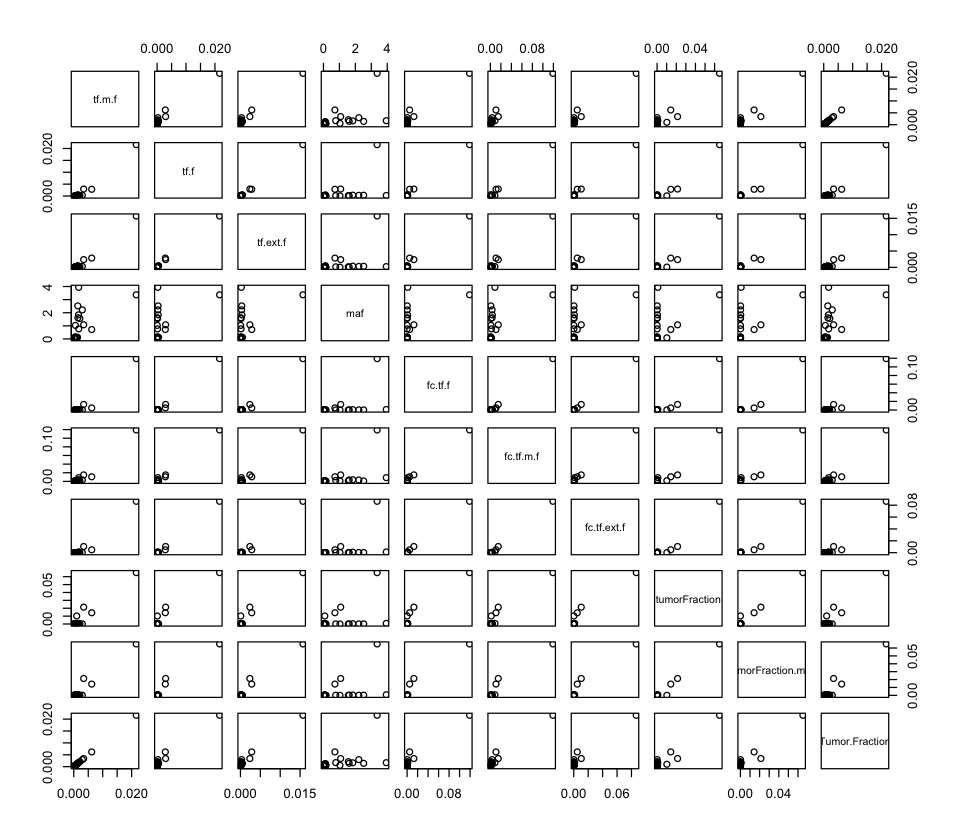

In [304]:
pairs(x = summary %>% select(stats), labels = stats)
#summary %>% relocate(stats)

# average VAF of confident variants, see code callMRD
# see also fc.tf.m.f * tumorFraction.baseline.adj = tumorFraction

[1] 37

Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
RD mean: 0.0025609587900599
pCR mean: 0.00062374362964489

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 249, p-value = 0.0185
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 pCR 0.02160589 p=0.018


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


Complete cases tumorFraction by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
RD mean: 0.00621442441111111
pCR mean: 0.000102371673684211

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 215, p-value = 0.1861
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2                 pCR      0.065141 p=0.186


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


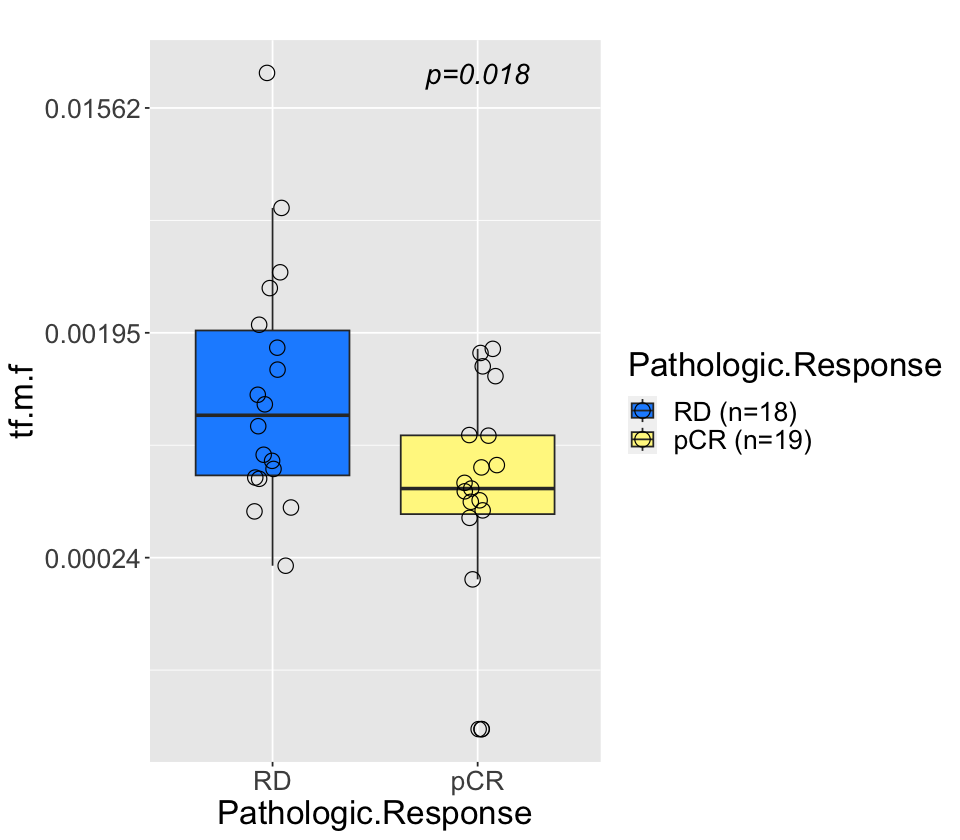

Complete cases tumorFraction.mrd by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
RD mean: 0.00565142831802652
pCR mean: 0.000102371377093042

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 207, p-value = 0.2806
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction.mrd   label
1                  RD                NA        
2                 pCR        0.06514085 p=0.281


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


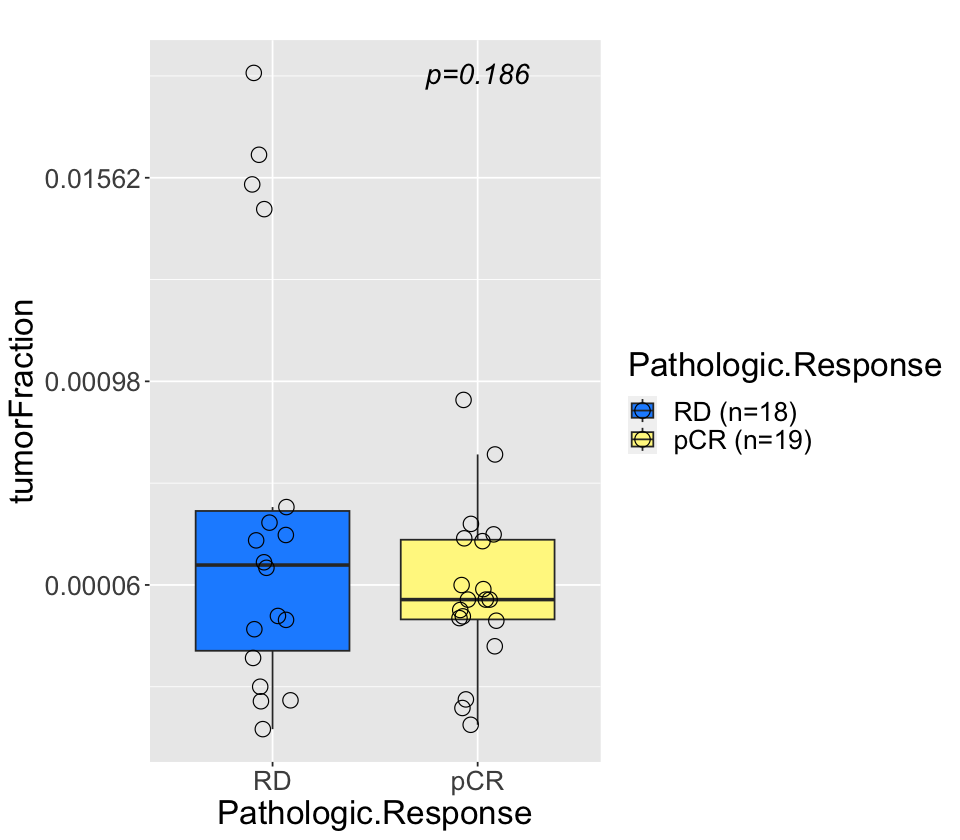

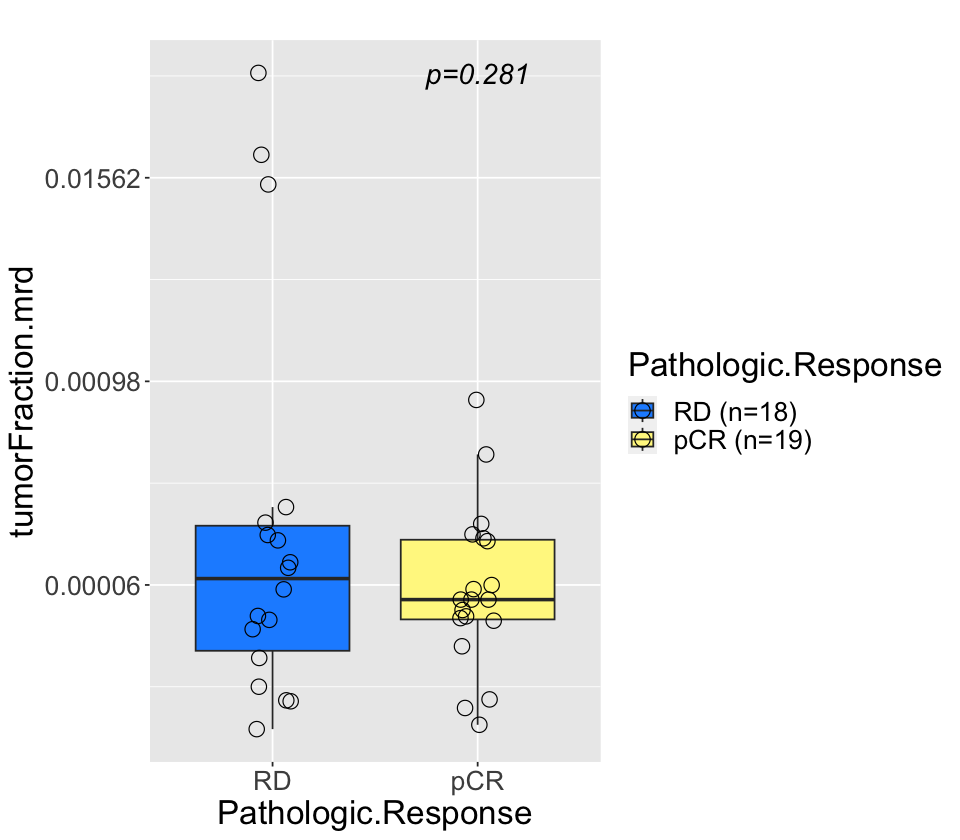

In [351]:
# NOTE: # really can't do TF correlation analysis with only one time point!!!, 
# confounded with unknown starting amt of ctDNA, logistic reg with covariate for T stage yield p=0.12 for TF to predict response

# original pipeline output
options(repr.plot.height=7, repr.plot.width=8)
source("~/Desktop/puffin/R/helper_functions.R")

df = summary %>% mutate(Tumor.Fraction=Tumor.Fraction*100) %>% filter(PatientID %in% mrd.qc.pass$PatientID) %>%
            filter(!is.na(tf.m.f))
nrow(df)
# figure: 
# quick_boxplot(df = df, x = "Pathologic.Response", y = "Tumor.Fraction", log.axes=TRUE, replace.log.0=0.005,
#               print.p = TRUE, plot.title = glue("Tumor.Fraction by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))

# compare
quick_boxplot(df = df, x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, replace.log.0=0.00005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = df, x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE, replace.log.0=0.00005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = df, x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE, replace.log.0=0.00005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))

# stats=c("tf.m.f","tf.f","tf.ext.f","maf","fc.tf.f","fc.tf.m.f","fc.tf.ext.f","tumorFraction",
#     "tumorFraction.mrd")
# pdf("./mrd_results/TF_by_PathResponse_boxplot_06282023.pdf", onefile=TRUE)
# for (stat in stats){
#     quick_boxplot(df = summary, x = "Pathologic.Response", y = stat, log.axes=TRUE, replace.log.0=0.000005,
#               print.p = TRUE, plot.title = glue("{stat} by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))
# }
# dev.off()

Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
[1] "y"
Level: T1
RD mean: 0.0023267940017467
pCR mean: 0.000658149348788176

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 17, p-value = 0.5791
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response      tf.m.f   label
1                  RD          NA        
2                 pCR 0.006199148 p=0.579
Level: T2
RD mean: 0.00316114130789441
pCR mean: 0.00065633526272211

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 56, p-value = 0.1236
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 pCR 0.021

Warning message:
“Removed 3 rows containing missing values (`geom_text()`).”


Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
[1] "y"
Level: pN-
RD mean: 0.00142762886387051
pCR mean: 0.000809767442982926

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 58, p-value = 0.4636
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response      tf.m.f   label
1                  RD          NA        
2                 pCR 0.006199148 p=0.464
Level: pN+
RD mean: 0.00482761864243868
pCR mean: 0.000488453583580865

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 58, p-value = 0.01375
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 pCR 

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


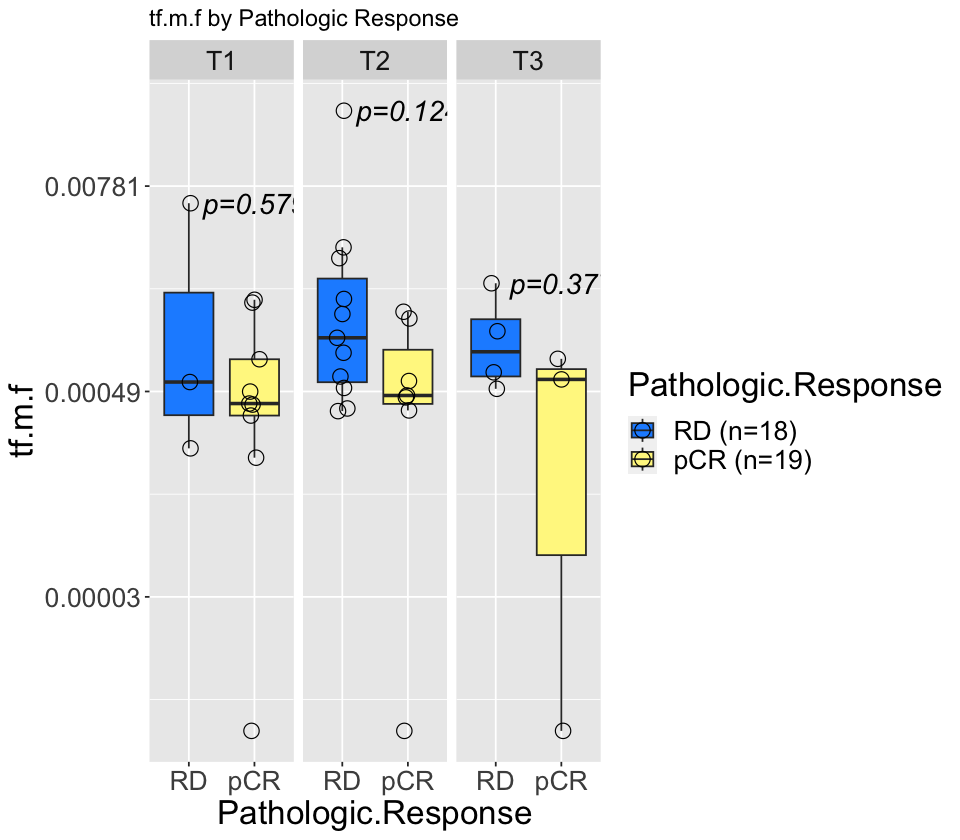

    
     pN- pN+
  T1   9   5
  T2  13  10
  T3   2   5

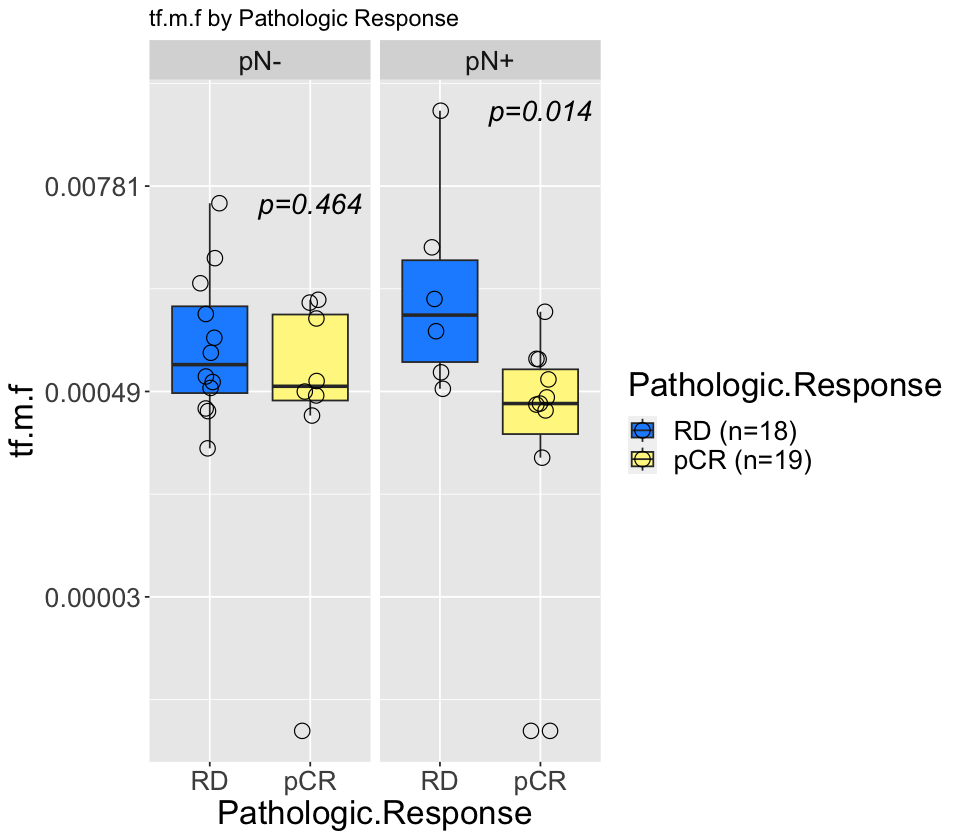

In [336]:
# stratify by pT and pN # N.S.
source("~/Desktop/puffin/R/helper_functions.R")
summary = summary %>% mutate(N.Group=factor(ifelse(N.Stage %in% c("N0"), "pN-", "pN+"), 
                                            levels=c("pN-","pN+"), order=TRUE)) %>% filter(PatientID %in% mrd.qc.pass$PatientID)

quick_boxplot(df = summary, facet="T.Stage", x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, plot.title = glue("tf.m.f by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = summary, facet="N.Group", x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, plot.title = glue("tf.m.f by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))

# quick_boxplot(df = summary, facet="T.Stage", x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE,
#               print.p = TRUE, plot.title = glue("tumorFraction.mrd by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))

# quick_boxplot(df = summary, facet="N.Group", x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE,
#               print.p = TRUE, plot.title = glue("tumorFraction.mrd by Pathologic Response"), colors=c("RD"="dodgerblue","pCR"="khaki1"))

table(summary$T.Stage, summary$N.Group)

Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
[1] "y"
Level: FALSE
RD mean: 0.000991631408896038
pCR mean: 0.000608708143488427

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 162, p-value = 0.1008
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response      tf.m.f   label
1                  RD          NA        
2                 pCR 0.002953119 p=0.101
Level: TRUE
RD mean: 0.0104075956958792
pCR mean: 0.000703932889146028

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 9, p-value = 0.08086
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 p

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


Complete cases tumorFraction.mrd by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
[1] "y"
Level: FALSE
RD mean: 5.08326626273355e-05
pCR mean: 9.28124420732843e-05

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 188.5, p-value = 0.815
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction.mrd   label
1                  RD      0.0007583716 p=0.815
2                 pCR                NA        
Level: TRUE
RD mean: 0.0335911942119492
pCR mean: 9.83896029126769e-05

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 9, p-value = 0.08086
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction.mrd   label
1                  RD  

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


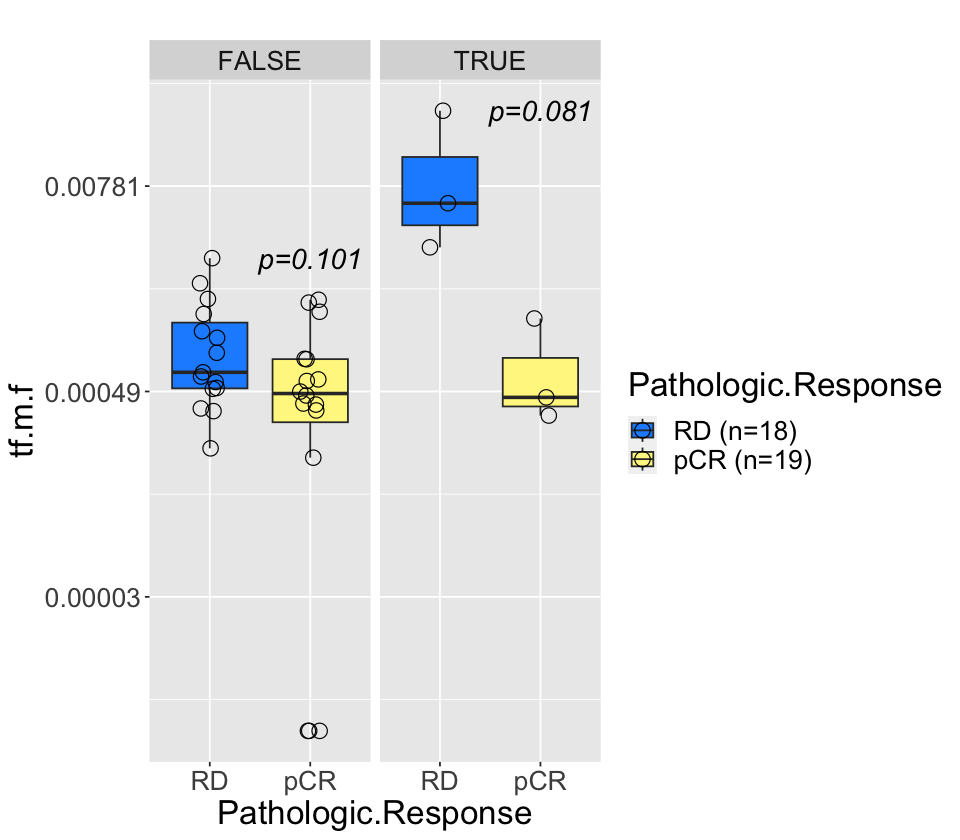

Complete cases tumorFraction by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
[1] "y"
Level: FALSE
RD mean: 0.0005546125
pCR mean: 9.16605444444444e-05

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 188, p-value = 0.8253
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2                 pCR      0.010191 p=0.825
Level: TRUE
RD mean: 0.0335913333333333
pCR mean: 9.83906666666667e-05

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 9, p-value = 0.08086
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2       

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


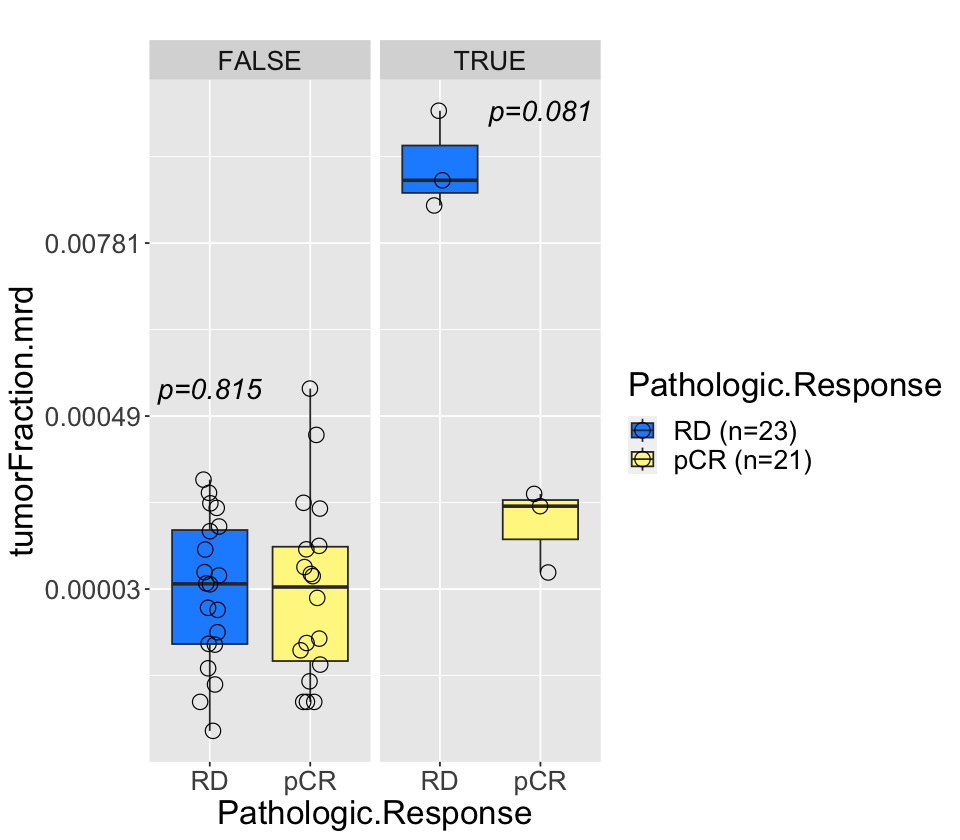

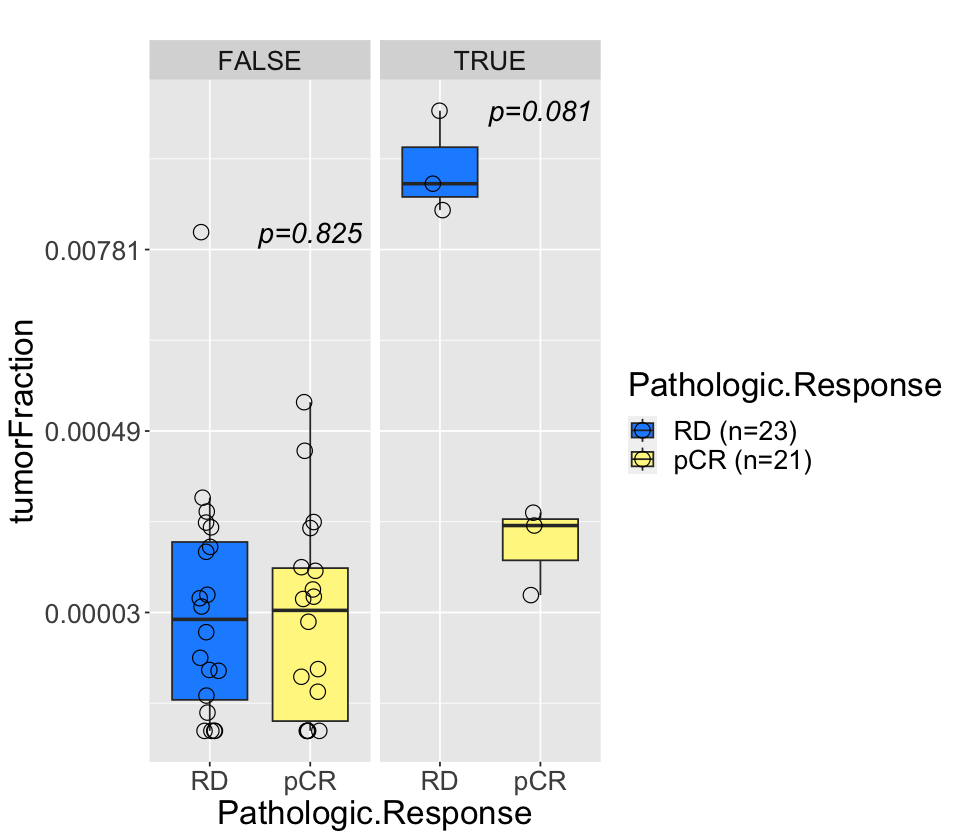

In [335]:
# stratify by mrd.status
source("~/Desktop/puffin/R/helper_functions.R")
summary = summary %>% mutate(mrd.status=factor(mrd.status, levels=c("FALSE","TRUE"))) %>% filter(PatientID %in% mrd.qc.pass$PatientID)

quick_boxplot(df = summary, facet="mrd.status", x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))

quick_boxplot(df = summary, facet="mrd.status", x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))

quick_boxplot(df = summary, facet="mrd.status", x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, colors=c("RD"="dodgerblue","pCR"="khaki1"))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”


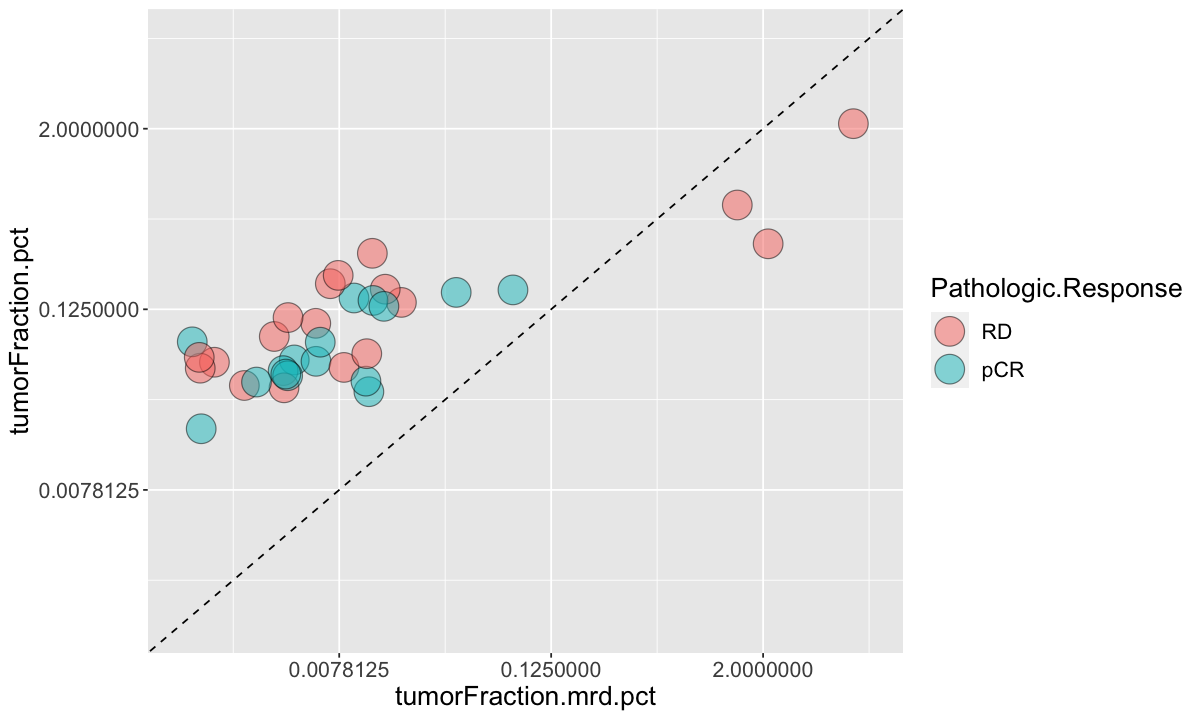

In [211]:
# correlation of TF measures
summary = summary %>% mutate(tumorFraction.pct=as.numeric(tf.m.f)*100, tumorFraction.mrd.pct=as.numeric(tumorFraction.mrd)*100)
options(repr.plot.width=10, repr.plot.height=6)
ggplot(summary, aes(tumorFraction.mrd.pct, tumorFraction.pct, fill=Pathologic.Response)) +
    geom_point(pch=21, size=8, alpha=0.5) + 
    geom_abline(slope=1, intercept=c(0,0), linetype="dashed") +
    #xlim(0,8) +
    #ylim(0,8) +
    scale_y_continuous(trans='log2',limits = c(0.001,8)) +
    scale_x_continuous(trans='log2', limits=c(0.001,8)) +
    theme(text=element_text(size=16))

Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
RD mean: 0.00253368560639242
pCR mean: 0.00062374362964489

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 249, p-value = 0.0185
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 pCR 0.02111497 p=0.018


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


Complete cases tumorFraction by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
RD mean: 0.00489426326086957
pCR mean: 0.000135897047619048

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 270, p-value = 0.5088
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2                 pCR      0.065141 p=0.509


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


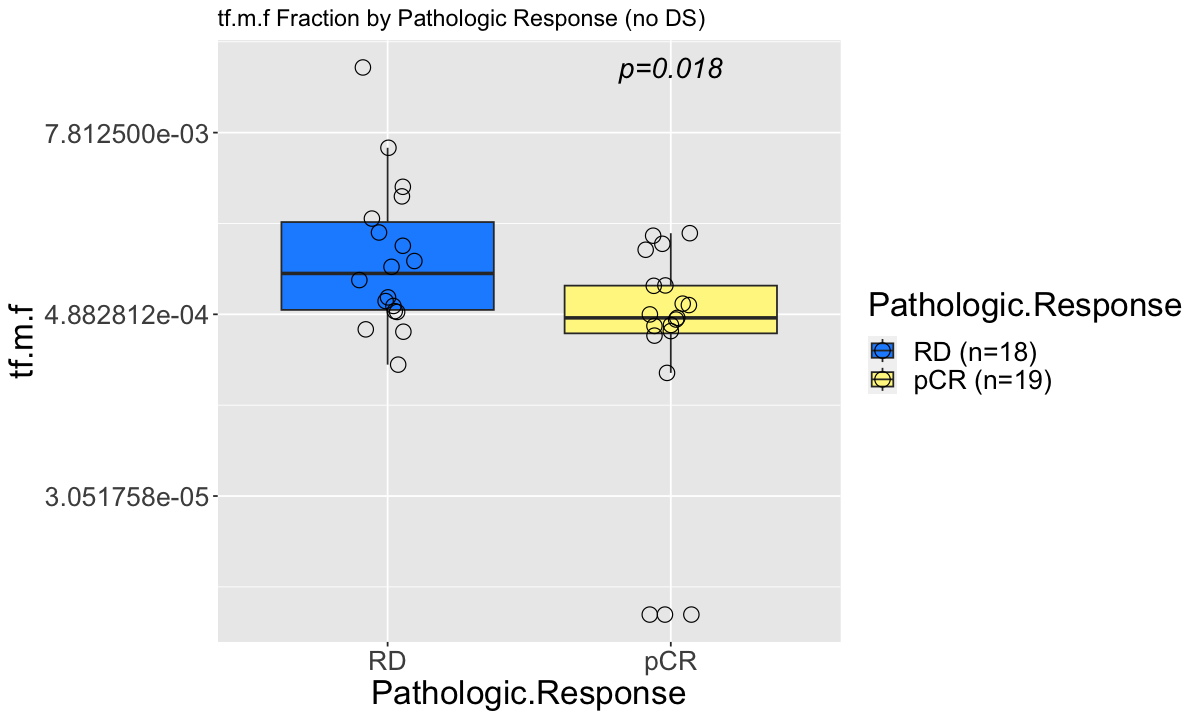

Complete cases tf.m.f by Pathologic.Response: 37
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 19    pCR (n=19) khaki1    
[1] "y"
Level: FALSE
RD mean: 0.000963009660514657
pCR mean: 0.000365921982729544

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 82, p-value = 0.06169
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response      tf.m.f   label
1                  RD          NA        
2                 pCR 0.002953119 p=0.062
Level: TRUE
RD mean: 0.00449703053873962
pCR mean: 0.000978248394153492

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 48, p-value = 0.1036
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


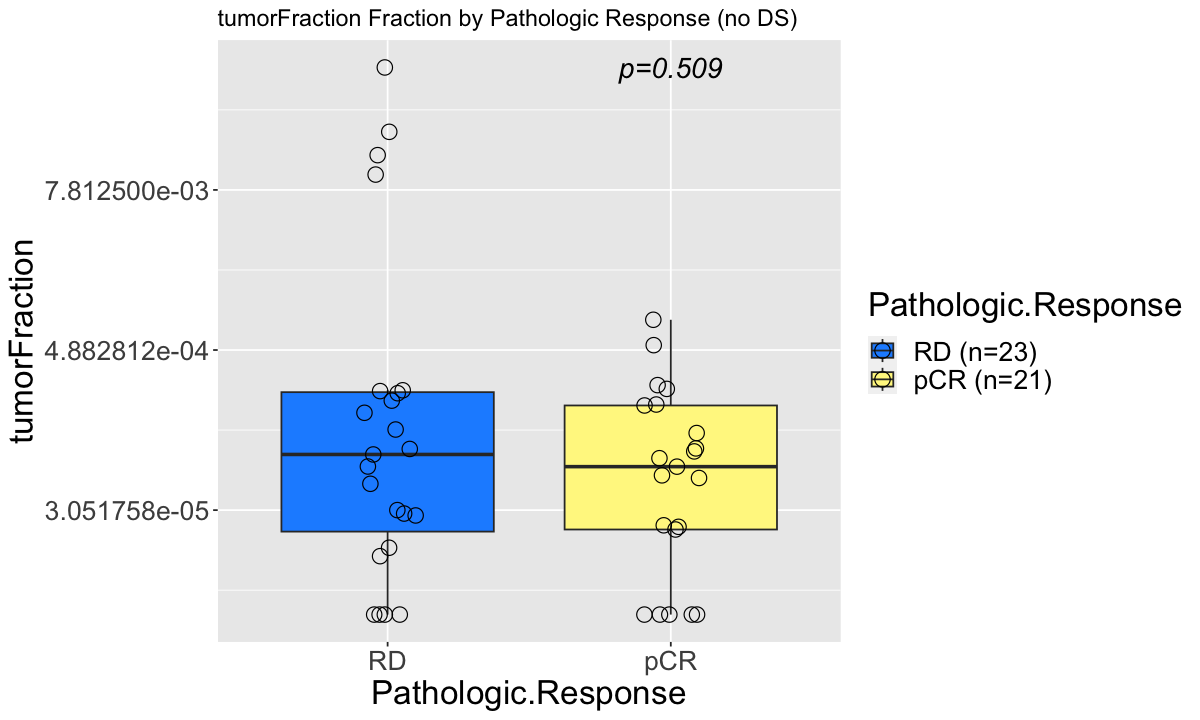

Complete cases tumorFraction by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
[1] "y"
Level: FALSE
RD mean: 5.34903333333333e-05
pCR mean: 3.36102307692308e-05

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 111, p-value = 0.5426
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2                 pCR    0.00023975 p=0.543
Level: TRUE
RD mean: 0.0139707125
pCR mean: 0.000302113125

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 46, p-value = 0.1563
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response tumorFraction   label
1                  RD            NA        
2           

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


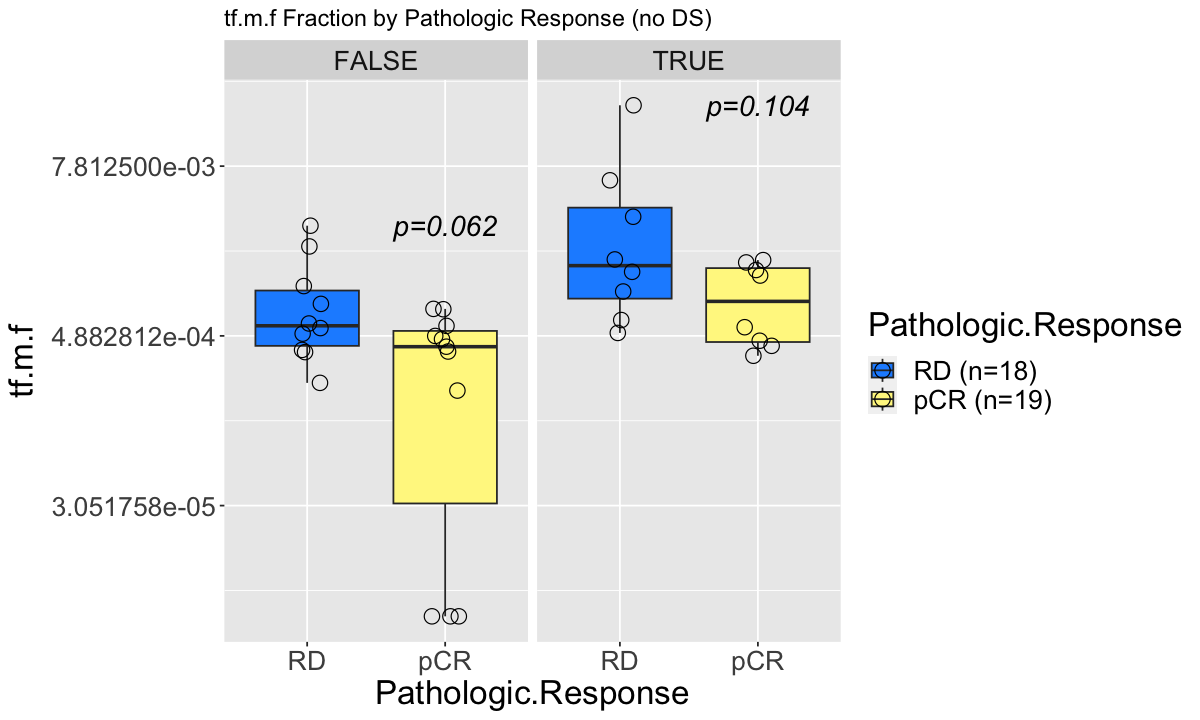

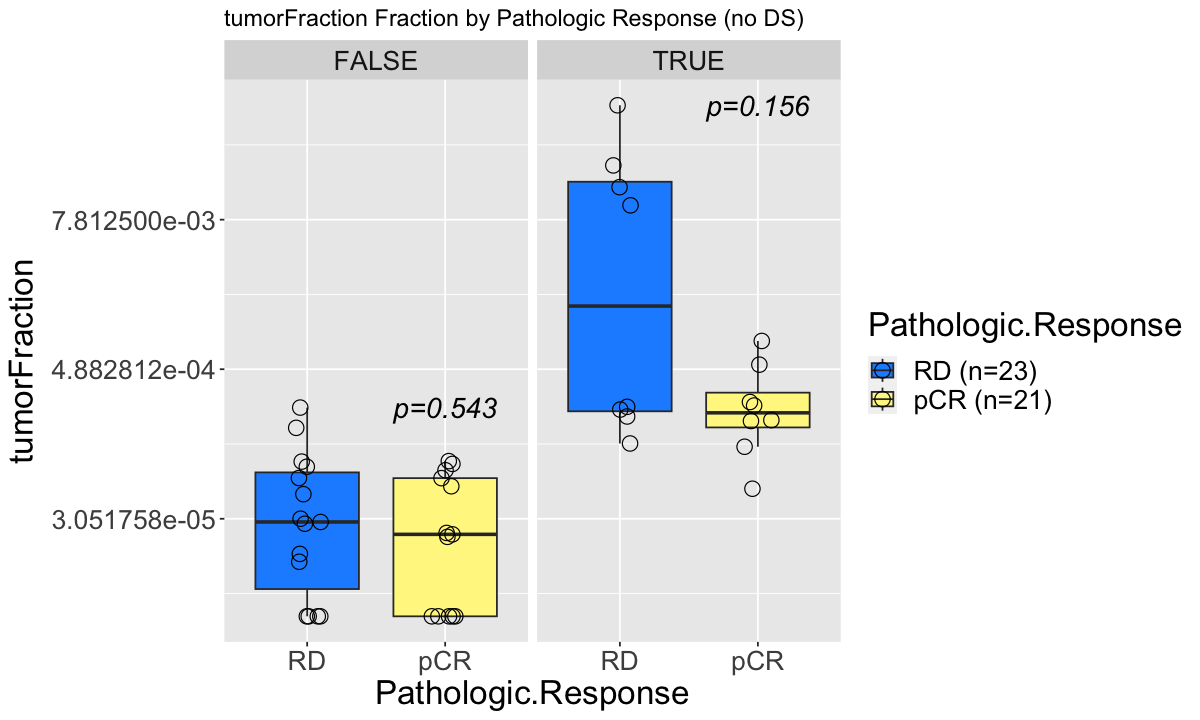

In [253]:
# removing DS support requirements, not better
mrd.noDS = make_names(read.csv("./mrd_results/mrdInfo_noDS_all_2023-06-21.csv", as.is=T)) %>%
                select(PatientID, tumorFraction, tumorFraction.mrd, tf.m.f, mrd.score, mrd.status,
                      mutationCount.mrd, mutationCount) %>%
                left_join(clin.data, by="PatientID") %>% 
                mutate_at(all_of(c("tf.m.f","tumorFraction","tumorFraction.mrd")), as.numeric)%>%
            mutate(mrd.status=factor(mrd.status, levels=c("FALSE","TRUE")),
                  PatientID=SubjectID,
                  tumorFraction.mrd = ifelse(mutationCount.mrd==0, 0, tumorFraction.mrd),# replaces two values
                  tumorFraction = ifelse(mutationCount==0, 0, tumorFraction),
                  tf.m.f = ifelse(mutationCount.mrd==0, 0, tf.m.f)) %>%
            filter(SampleID %in% mrd.qc.pass$SampleID)

quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, plot.title = "tf.m.f Fraction by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE, replace.log.0=0.000005,
              print.p = TRUE, plot.title = "tumorFraction Fraction by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
                          
quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, facet="mrd.status", replace.log.0=0.000005,
              print.p = TRUE, plot.title = "tf.m.f Fraction by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE, facet="mrd.status", replace.log.0=0.000005,
              print.p = TRUE, plot.title = "tumorFraction Fraction by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))


# quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE,
#               print.p = TRUE, plot.title = "Tumor Fraction by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

# quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE,
#               print.p = TRUE, plot.title = "tumorFraction.mrd by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

# quick_boxplot(df = mrd.noDS, x = "Pathologic.Response", y = "mrd.score", log.axes=TRUE,
#               print.p = TRUE, plot.title = "mrd.score by Pathologic Response (no DS)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

Warning message:
“There were 3 warnings in `summarize()`.
The first warning was:
ℹ In argument: `Mean.mrd.score = mean(as.numeric(mrd.score) * 100, na.rm = T)`.
ℹ In group 2: `CancerStage = T1N1`.
Caused by warning in `mean()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


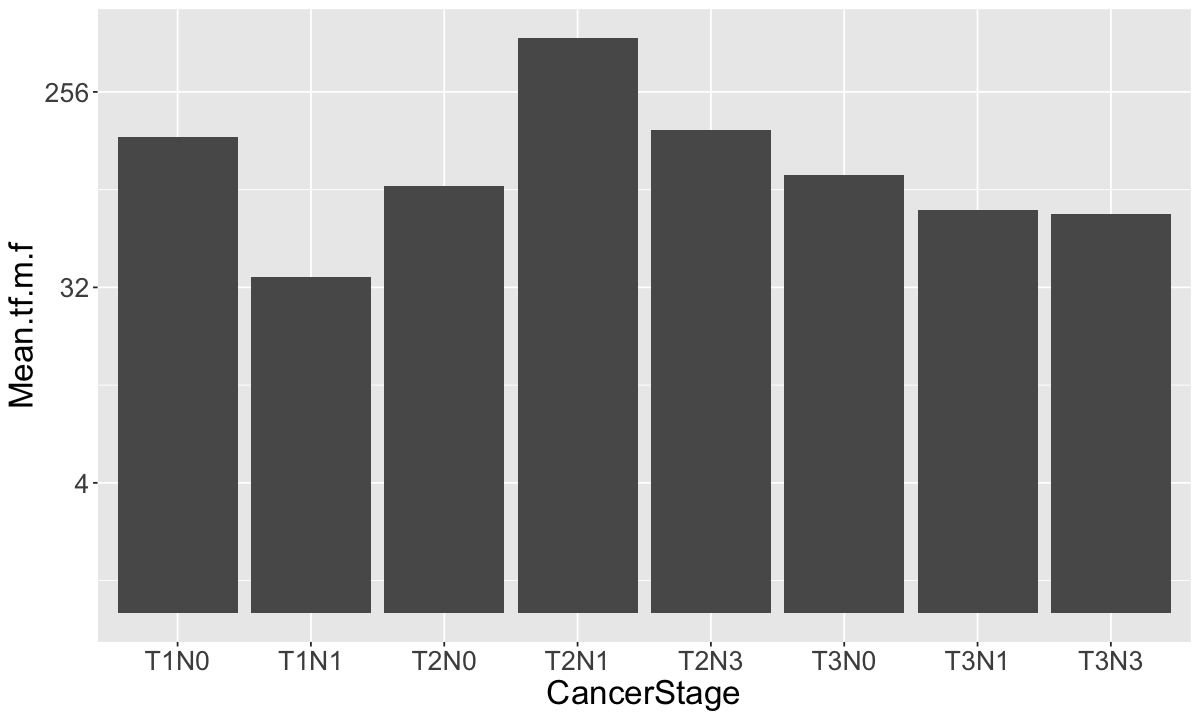

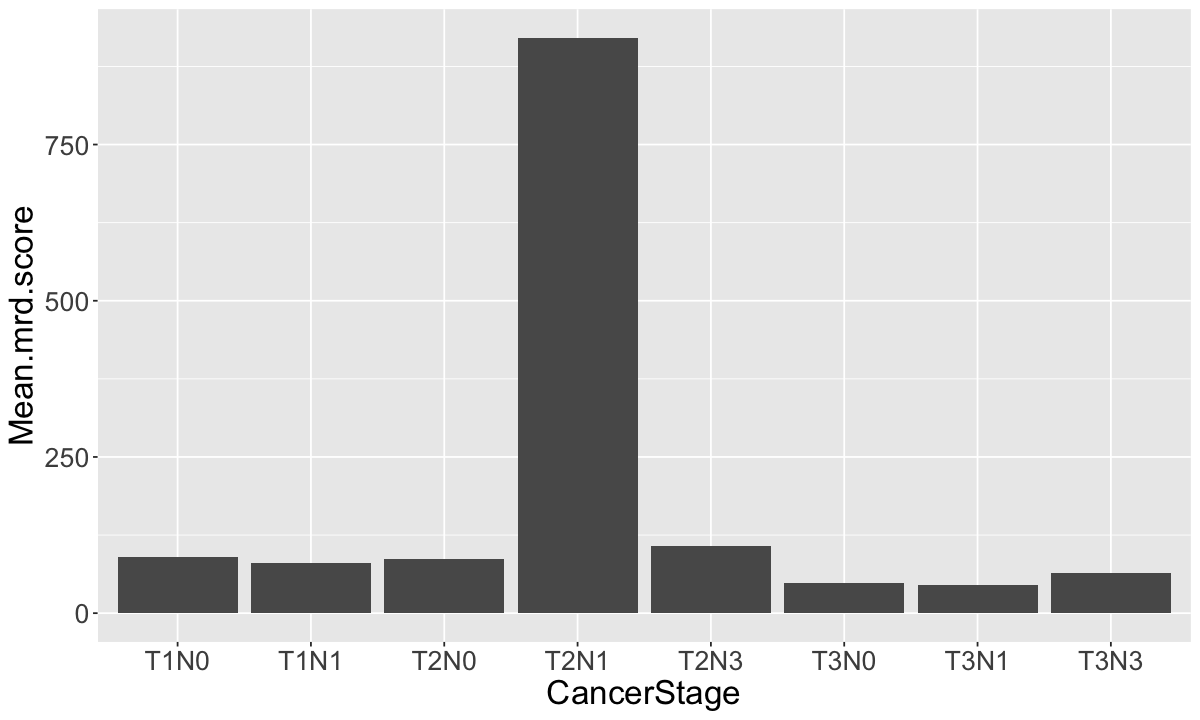

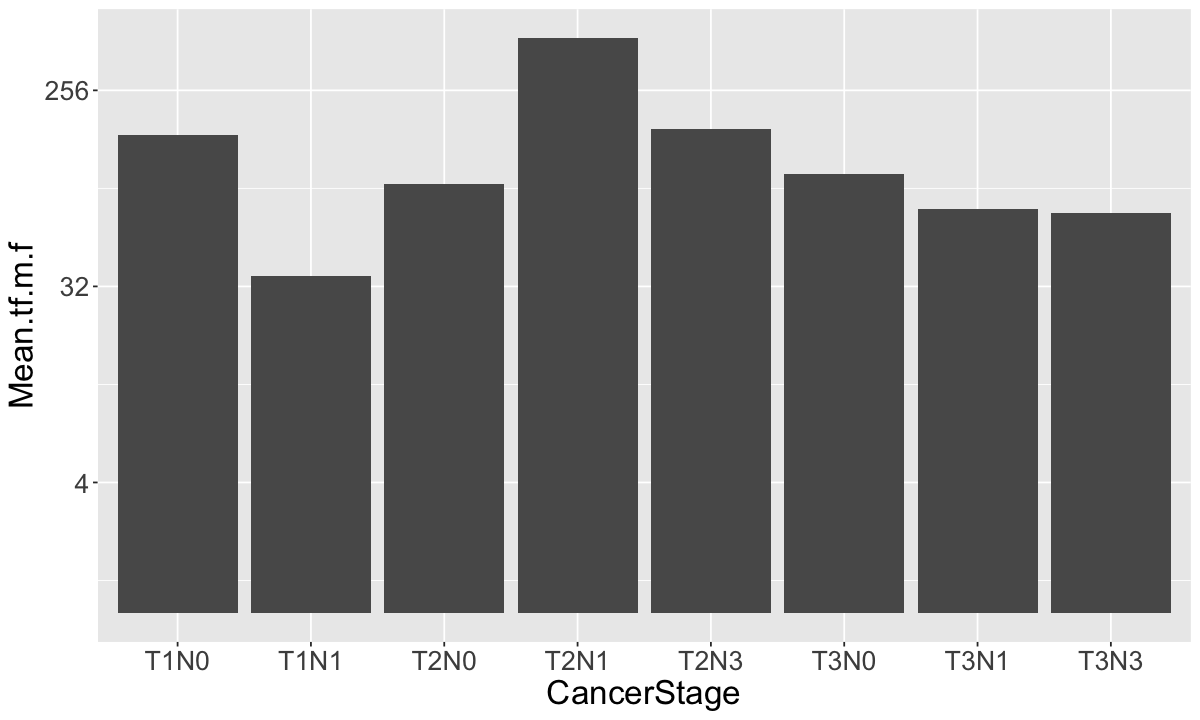

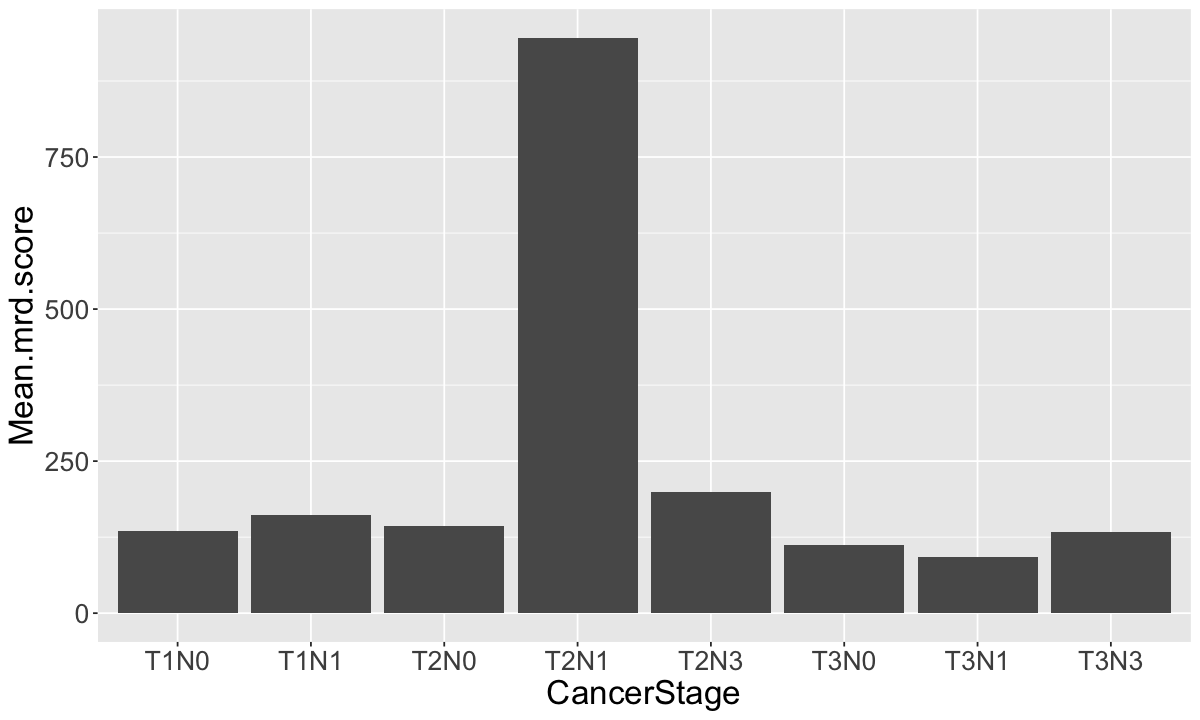

In [248]:
# by stage - no trends
bar_plot_ <- function(df, x, y, log.axis=FALSE){
    gg <- ggplot(df, aes_string(x=x, y=y)) + 
        geom_col() + 
        theme(text=element_text(size=20))
    if (log.axis){
        gg <- gg + scale_y_continuous(trans='log2')
    }
    show(gg)
}

df.mean = summary %>% group_by(CancerStage) %>% 
            summarize("Mean.tf.m.f"=mean(as.numeric(tf.m.f)*100000, na.rm=T),
                      "Mean.mrd.score"=mean(as.numeric(mrd.score)*100, na.rm=T))
bar_plot_(df.mean, "CancerStage", "Mean.tf.m.f", log.axis=TRUE)
bar_plot_(df.mean, "CancerStage", "Mean.mrd.score", log.axis=FALSE)

df.mean.noDS = mrd.noDS %>% group_by(CancerStage) %>% 
            summarize("Mean.tf.m.f"=mean(as.numeric(tf.m.f)*100000, na.rm=T),
                      "Mean.mrd.score"=mean(as.numeric(mrd.score)*100, na.rm=T))
bar_plot_(df.mean.noDS, "CancerStage", "Mean.tf.m.f", log.axis=TRUE)
bar_plot_(df.mean.noDS, "CancerStage", "Mean.mrd.score", log.axis=FALSE)

Warning message:
“Use of `df[[x]]` is discouraged.
ℹ Use `.data[[x]]` instead.”
Warning message:
“Use of `df[[y]]` is discouraged.
ℹ Use `.data[[y]]` instead.”


       
        RD pCR
  FALSE 20  18
  TRUE   3   3



	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1311894 9.3712394
sample estimates:
odds ratio 
  1.108449 


Warning message:
“Use of `df[[x]]` is discouraged.
ℹ Use `.data[[x]]` instead.”
Warning message:
“Use of `df[[y]]` is discouraged.
ℹ Use `.data[[y]]` instead.”


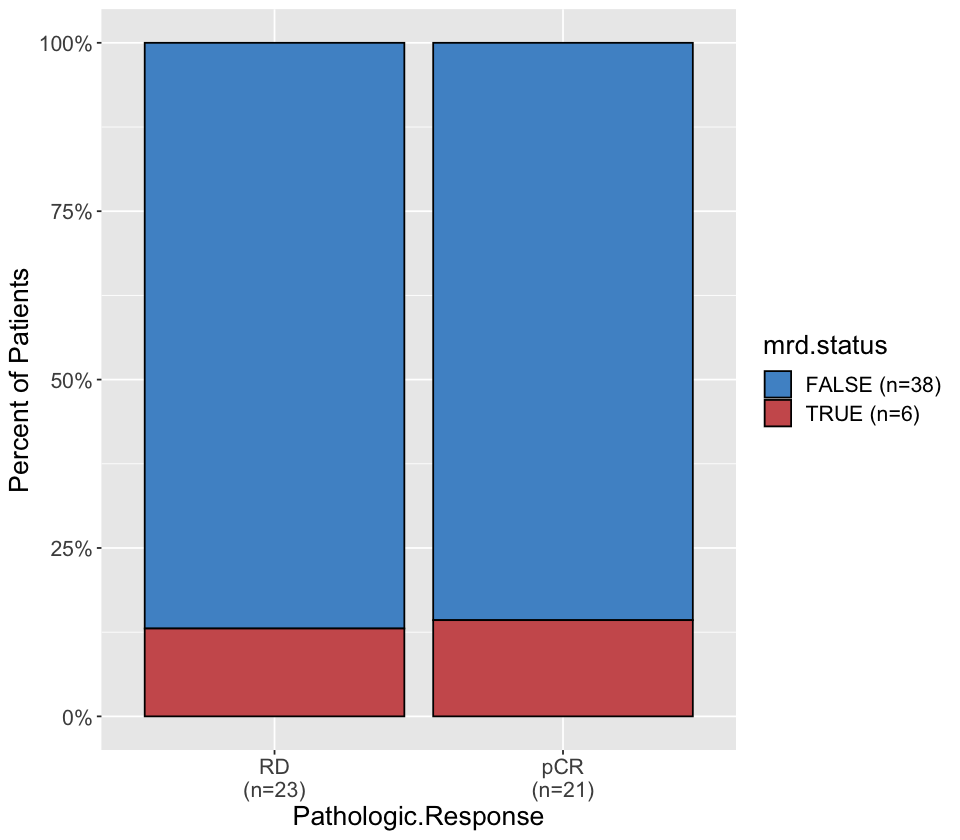

       
        RD pCR
  FALSE 15  13
  TRUE   8   8



	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2834078 4.6899402
sample estimates:
odds ratio 
  1.150091 


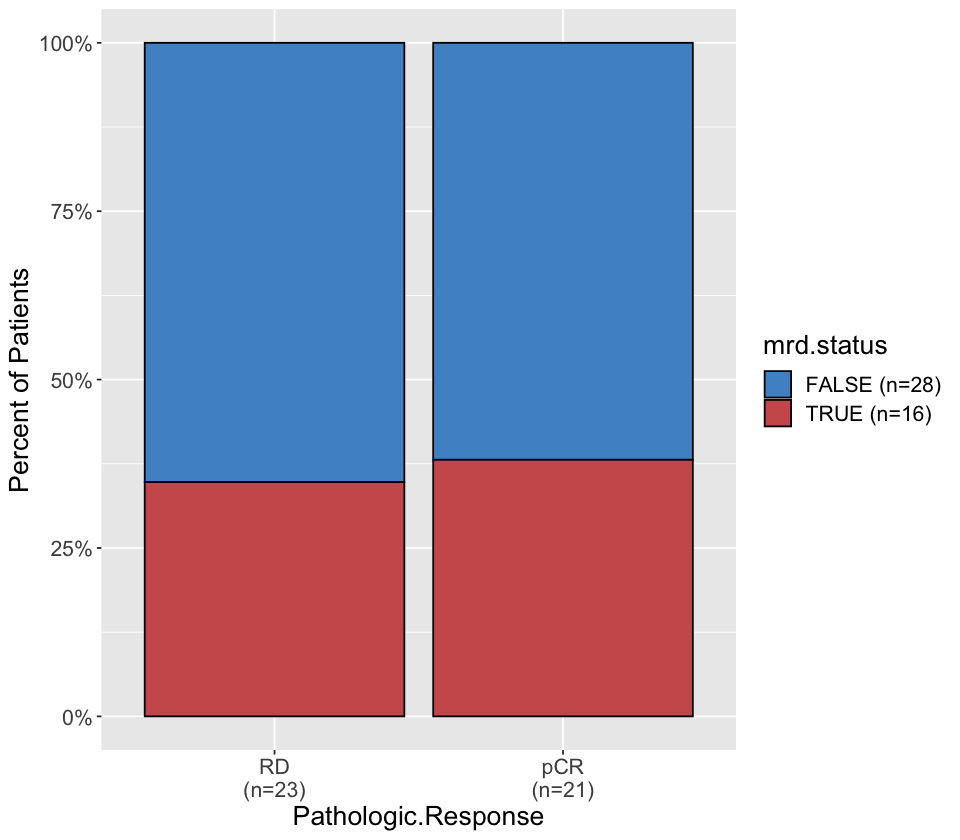

In [334]:
stacked_bar_ <- function(df, x = "Pathologic.Response", y="mrd.status", 
                         colors=c("steelblue3","indianred"), y.percent=TRUE){
    stopifnot(is.factor(df[[x]]))
    stopifnot(is.factor(df[[y]]))
    xlevs = levels(df[[x]])
    ylevs = levels(df[[y]])
    n.0 = sum(df$Pathologic.Response==xlevs[1])
    n.1 = sum(df$Pathologic.Response==xlevs[2])
    names(colors) <- as.character(ylevs)
   gg <- ggplot(df) +
      geom_bar(aes(x=df[[x]], fill=df[[y]]), position="fill", color="black") +
      scale_fill_manual(name = y, values=colors, labels=paste0(ylevs, " (n=", table(df[[y]]), ")")) +
      scale_x_discrete(labels=paste0(xlevs, "\n(n=", table(df[[x]]), ")")) +
      theme(text = element_text(size = 16))
    if (y.percent){
        gg <- gg + 
               scale_y_continuous(labels = scales::percent) + 
               labs(y="Percent of Patients", x=x)
    }
    show(gg)
    # rows response var, cols predictor
    tab = table(df[[y]], df[[x]])
    print(tab)
    fisher.test(as.matrix(tab))
    }

stacked_bar_(summary %>% filter(PatientID %in% mrd.qc.pass$PatientID))

stacked_bar_(mrd.noDS %>% mutate(mrd.status=factor(mrd.status)))



Complete cases tf.m.f by Pathologic.Response: 34
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 16    pCR (n=16) khaki1    
[1] "x"
RD mean: 0.00253776825862044
pCR mean: 0.000776324547779871

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 194, p-value = 0.08765
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2                 pCR 0.02111497 p=0.088


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


Complete cases tf.m.f by Pathologic.Response: 34
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  18    RD (n=18)  dodgerblue
2 pCR                 16    pCR (n=16) khaki1    
[1] "x"
[1] "y"
Level: FALSE
RD mean: 0.000996530591569658
pCR mean: 0.000793030315156911

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 116, p-value = 0.407
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response      tf.m.f   label
1                  RD          NA        
2                 pCR 0.002953119 p=0.407
Level: TRUE
RD mean: 0.0102439565938743
pCR mean: 0.000703932889146028

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 9, p-value = 0.08086
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response     tf.m.f   label
1                  RD         NA        
2           

Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


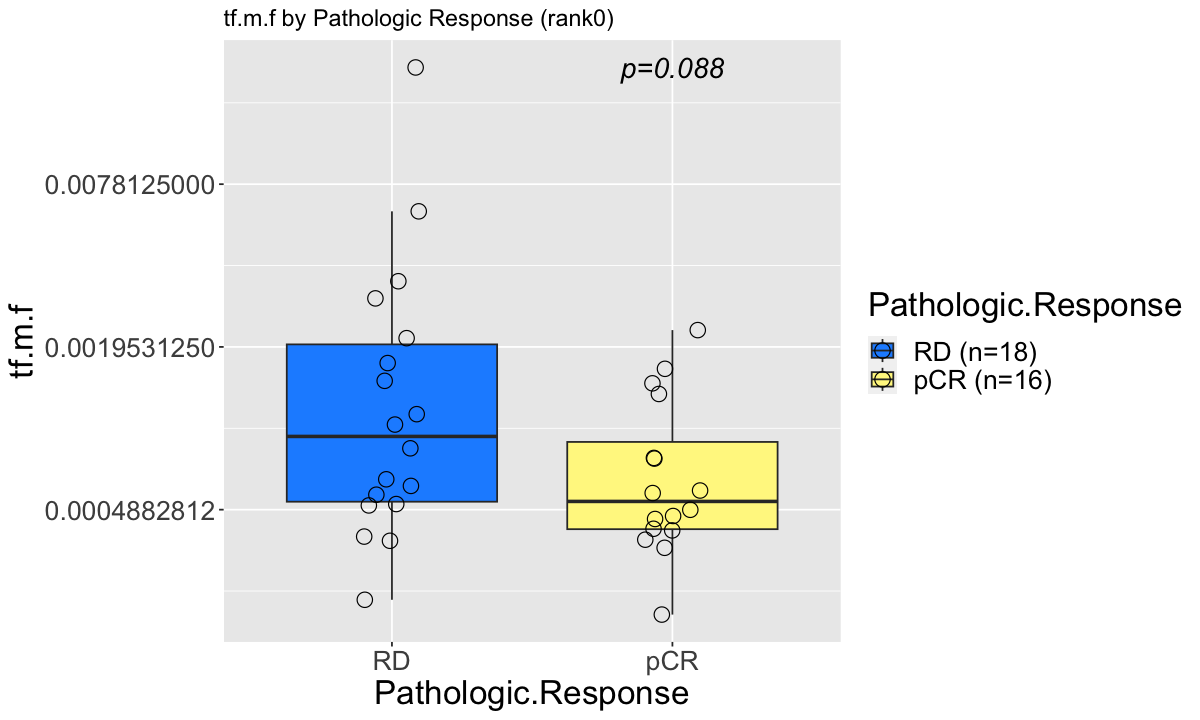

Warning message:
“Use of `df[[x]]` is discouraged.
ℹ Use `.data[[x]]` instead.”
Warning message:
“Use of `df[[y]]` is discouraged.
ℹ Use `.data[[y]]` instead.”


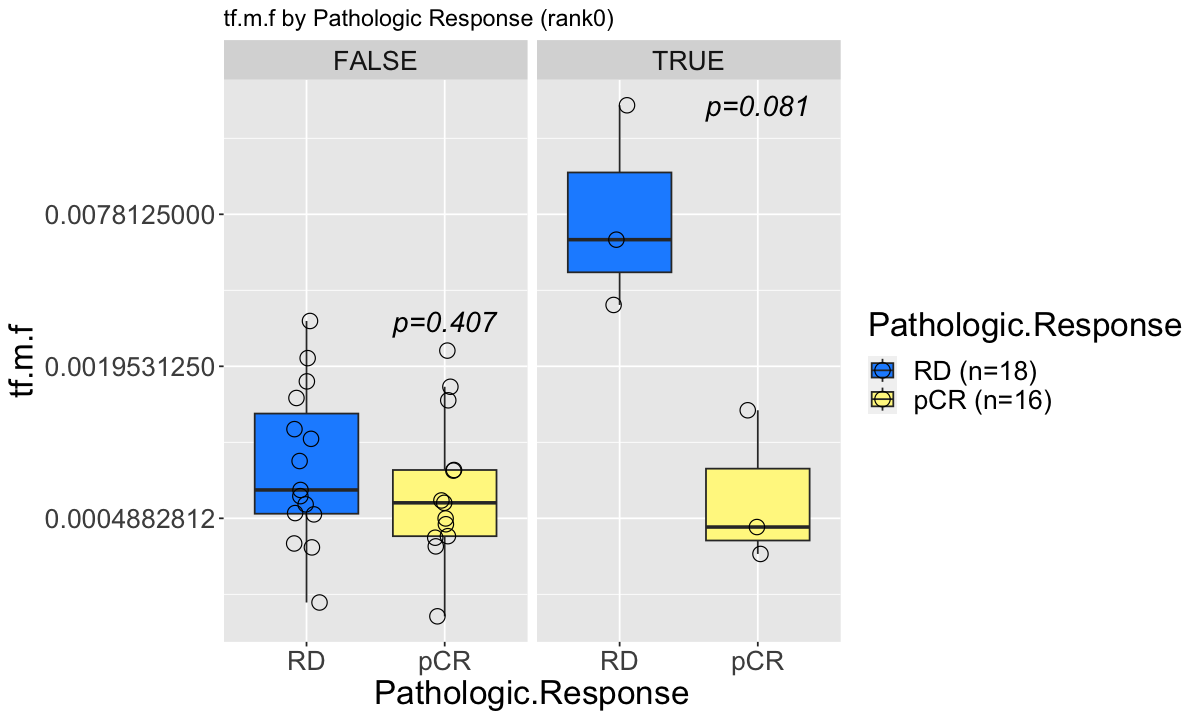

       
        RD pCR
  FALSE 20  18
  TRUE   3   3



	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1311894 9.3712394
sample estimates:
odds ratio 
  1.108449 


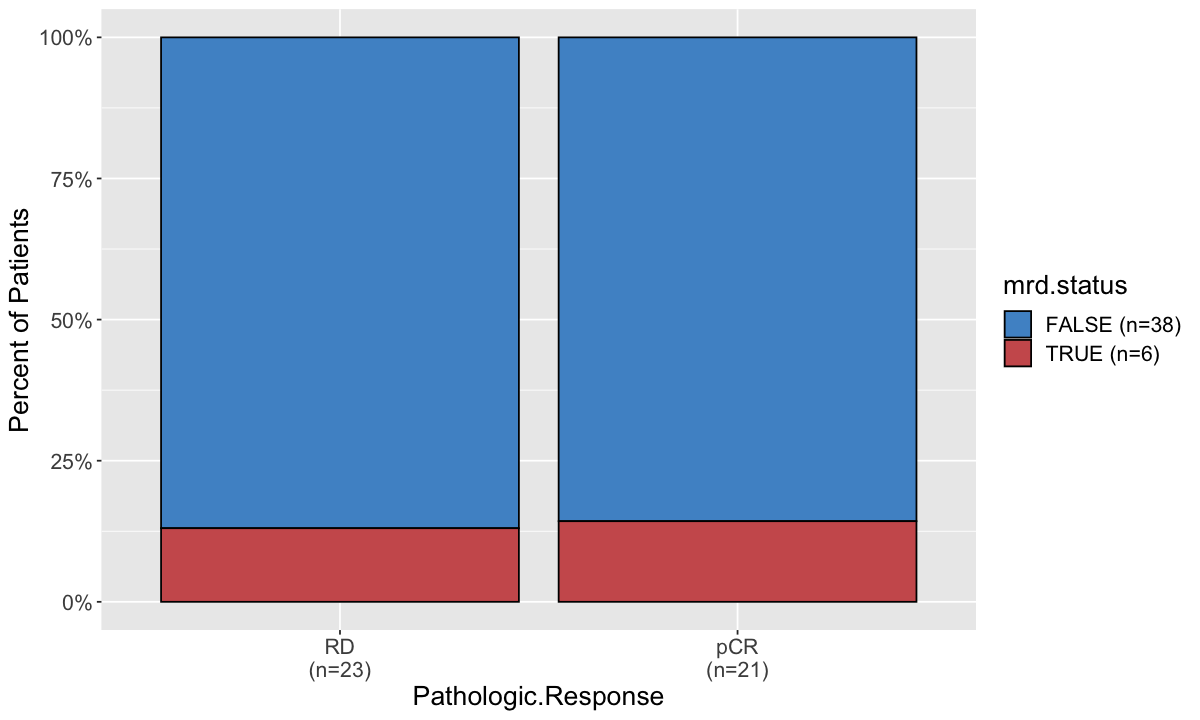

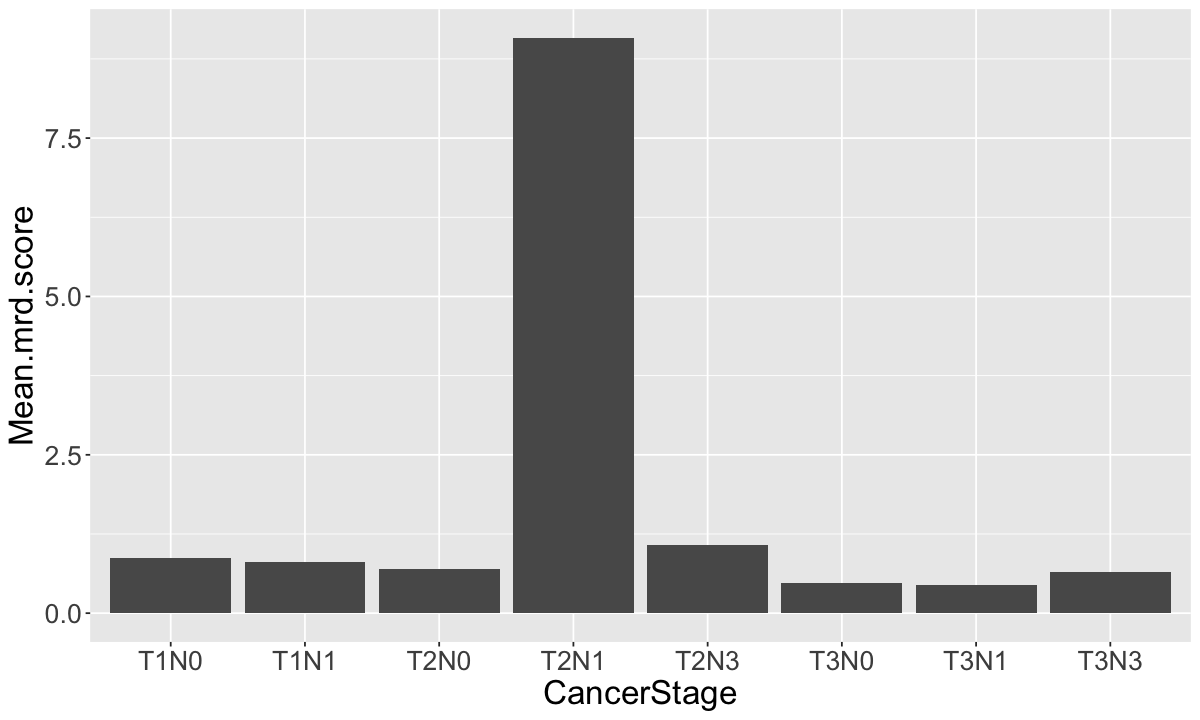

In [228]:
## use "tf.m.f" for generating mrdInfo # not better . . 
#infile = "./mrd_results/YALE_all_mrdInfo_tf_m_f2023-06-22.csv"

## repeat, use tf.m.f adn rank0 probes only for mrdInfo
infile = "./mrd_results/YALE_all_mrdInfo_tf_m_f_rank0_2023-06-26.csv"

source("~/Desktop/puffin/R/helper_functions.R")
mrd.tf.m.f = make_names(read.csv(infile, as.is=T)) %>% select(SampleID, mrd.status, mrd.score, tf.m.f, tumorFraction.mrd, tumorFraction) %>%
                mutate("mrd.status"=factor(mrd.status, levels=c("FALSE","TRUE"))) %>%
                left_join(clin.data %>% select(SampleID, Pathologic.Response, CancerStage, T.Stage, N.Stage), by="SampleID")
# critical!
stats=c("tf.m.f","tumorFraction","tumorFraction.mrd")
mrd.tf.m.f = mrd.tf.m.f %>% mutate_at(all_of(stats), as.numeric)

# by tf
# quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "tumorFraction.mrd", log.axes=TRUE,
#               print.p = TRUE, plot.title = "tumorFraction.mrd by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
# quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "tumorFraction", log.axes=TRUE,
#               print.p = TRUE, plot.title = "tumorFraction by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
# quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "mrd.score", log.axes=FALSE,
#               print.p = TRUE, plot.title = "mrd.score by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE,
              print.p = TRUE, plot.title = "tf.m.f by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "tf.m.f", log.axes=TRUE, facet="mrd.status",
              print.p = TRUE, plot.title = "tf.m.f by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))
# by mrd call
stacked_bar_(mrd.tf.m.f, x = "Pathologic.Response", y="mrd.status", y.percent=TRUE)

# by stage # may confound single timepoint tumor fraction measure
mrd.tf.m.f.mean = mrd.tf.m.f %>% group_by(CancerStage) %>% 
            summarize("Mean.tf.m.f"=mean(tf.m.f*100000, na.rm=T),
                      "Mean.tumorFraction.mrd"=mean(tumorFraction.mrd*100000, na.rm=T),
                      "Mean.mrd.score"=mean(mrd.score, na.rm=T))
bar_plot_(mrd.tf.m.f.mean, "CancerStage", "Mean.mrd.score", log.axis=FALSE)
#bar_plot_(mrd.tf.m.f.mean, "CancerStage", "Mean.tf.m.f", log.axis=FALSE)
#bar_plot_(mrd.tf.m.f.mean, "CancerStage", "Mean.tumorFraction.mrd", log.axis=FALSE)

,SampleID,PatientID,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,⋯,X.5,X.6,X.7,X.8,Pathologic.Response,CancerStage.y,T.Stage,N.Stage,pct.baseline.muts.detected,pct.baseline.muts.detected.all
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<ord>,<ord>,<ord>,<dbl>,<dbl>
1,P228248A01,MD0001,63,63,0,5,8,5,1.038983,1.04,⋯,NA,NA,NA,NA,RD,T3N3,T3,N3,0.12698413,0.12698413
2,P228249A01,MD0003,63,48,20,7,10,5,1.850000,1.85,⋯,NA,NA,NA,NA,pCR,T1N0,T1,N0,0.35714286,0.20833333
3,P228250A01,MD0004,61,57,4,38,37,36,32.944444,32.90,⋯,NA,NA,NA,NA,RD,T2N1,T2,N1,0.69811321,0.64912281
4,P228251A01,MD0005,61,52,9,2,3,2,0.600000,0.60,⋯,NA,NA,NA,NA,pCR,T3N1,T3,N1,0.06976744,0.05769231
5,P228253A01,MD0007,62,59,3,0,0,0,NA,NA,⋯,NA,NA,NA,NA,pCR,T1N1,T1,N1,0.00000000,0.00000000
6,P228254A01,MD0013,61,58,3,1,1,1,0.250000,0.25,⋯,NA,NA,NA,NA,RD,T1N0,T1,N0,0.01818182,0.01724138


Complete cases pct.baseline.muts.detected.all by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
[1] "x"
RD mean: 0.130026317964208
pCR mean: 0.0826397014373879

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 268, p-value = 0.5411
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response pct.baseline.muts.detected.all   label
1                  RD                             NA        
2                 pCR                      0.7142857 p=0.541


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


Complete cases pct.baseline.muts.detected by Pathologic.Response: 44
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  23    RD (n=23)  dodgerblue
2 pCR                 21    pCR (n=21) khaki1    
[1] "x"
RD mean: 0.147685226759729
pCR mean: 0.103989920152566

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 271.5, p-value = 0.488
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response pct.baseline.muts.detected   label
1                  RD                         NA        
2                 pCR                  0.8333333 p=0.488


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


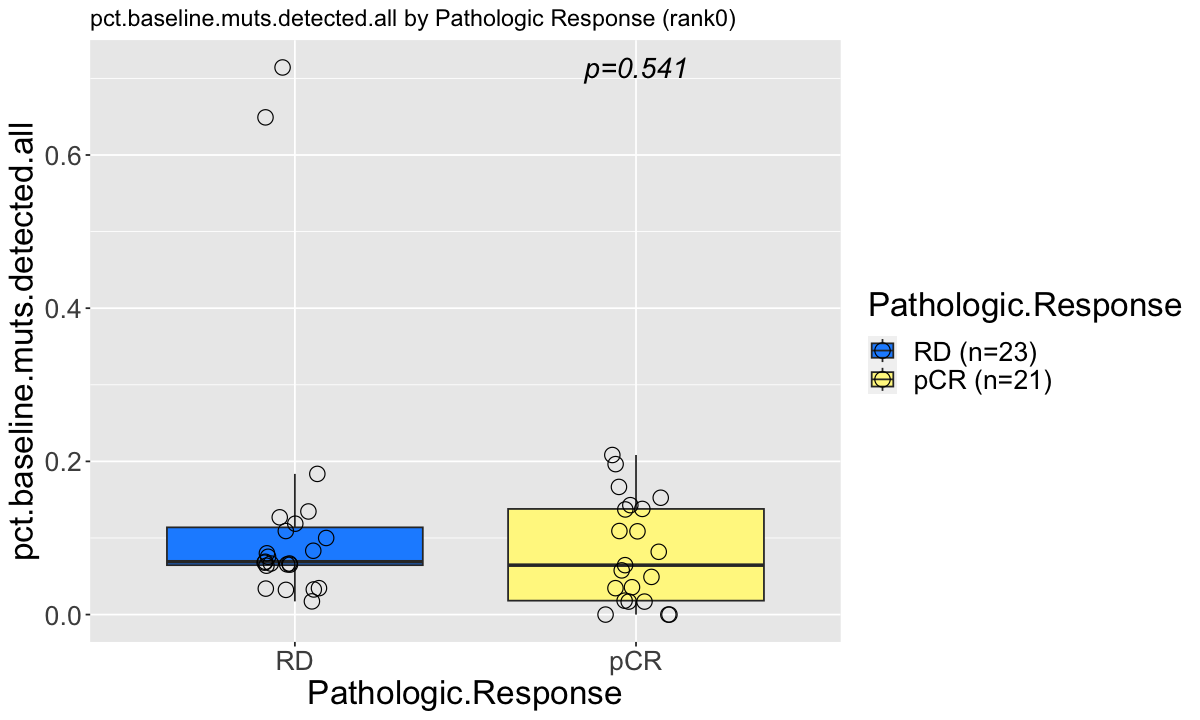

Complete cases pct.baseline.muts.detected.all by Pathologic.Response: 48
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  24    RD (n=24)  dodgerblue
2 pCR                 24    pCR (n=24) khaki1    
[1] "x"
RD mean: 0.131517782742066
pCR mean: 0.0801365209376633

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 347, p-value = 0.2275
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response pct.baseline.muts.detected.all   label
1                  RD                             NA        
2                 pCR                      0.7192982 p=0.227


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


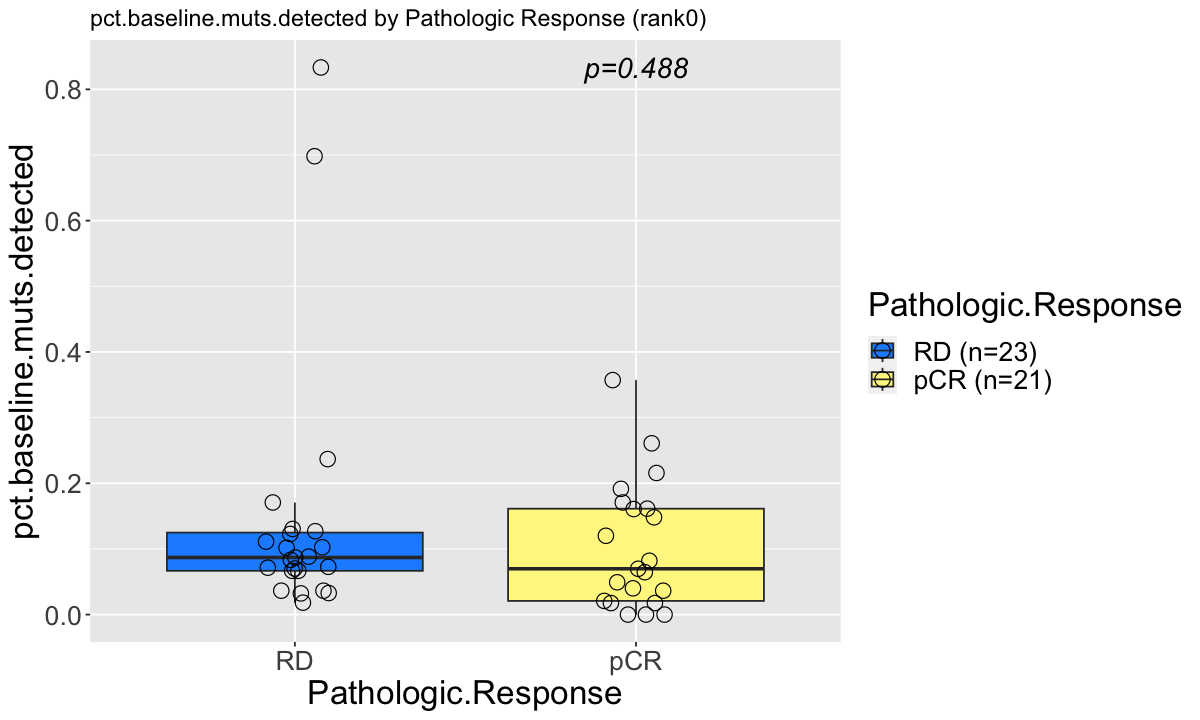

Complete cases pct.baseline.muts.detected by Pathologic.Response: 48
# A tibble: 2 × 4
  Pathologic.Response count legend     color     
  <chr>               <chr> <chr>      <chr>     
1 RD                  24    RD (n=24)  dodgerblue
2 pCR                 24    pCR (n=24) khaki1    
[1] "x"
RD mean: 0.146444657577692
pCR mean: 0.122674072559268

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 322.5, p-value = 0.4832
alternative hypothesis: true location shift is not equal to 0

  Pathologic.Response pct.baseline.muts.detected   label
1                  RD                         NA        
2                 pCR                  0.9534884 p=0.483


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


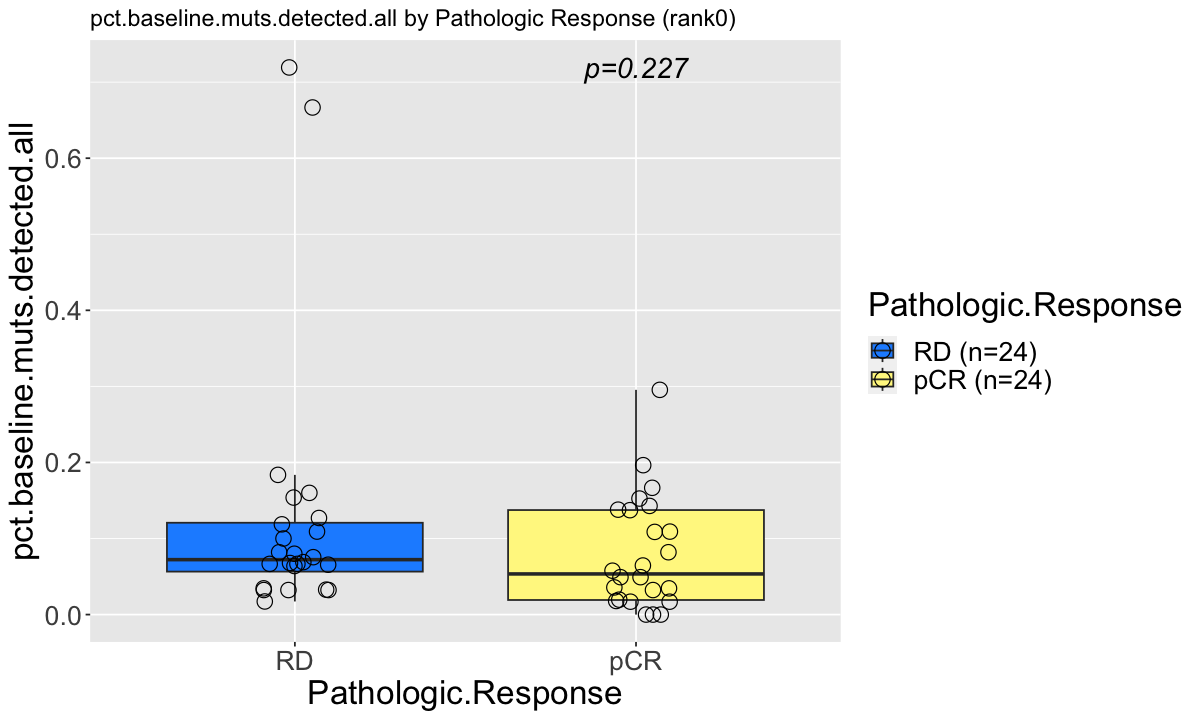

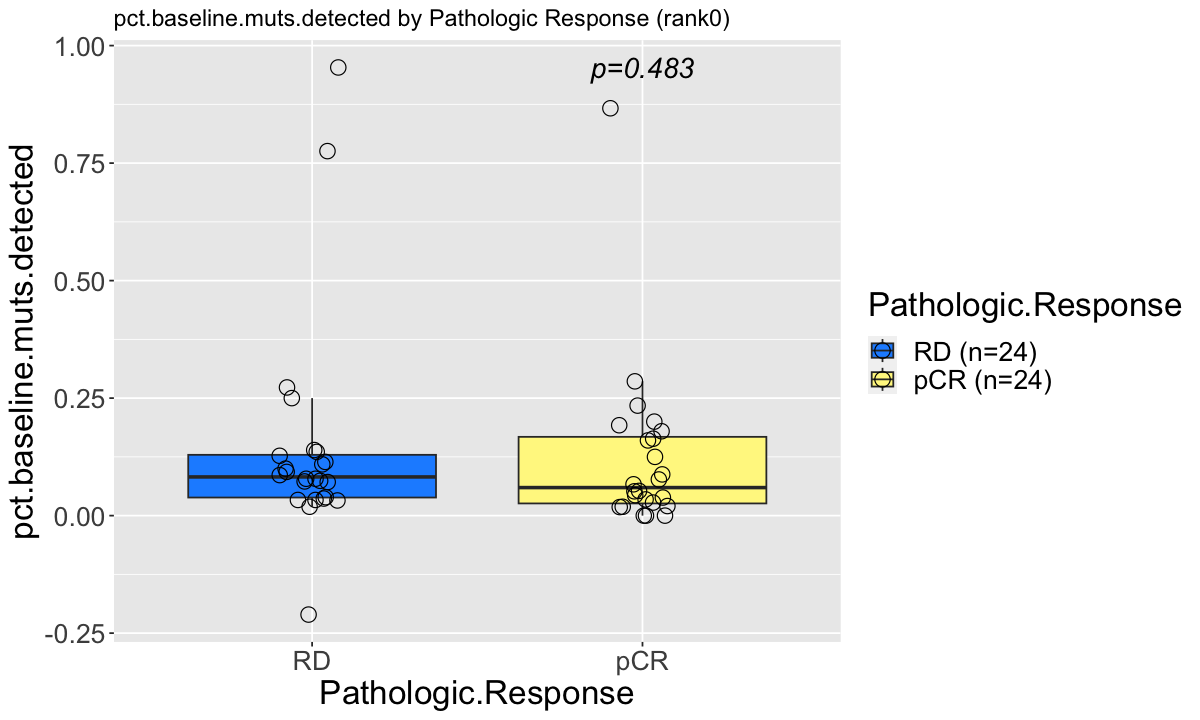

In [217]:
# mutational counts/percents - N.S.
infile = "./mrd_results/YALE_all_mrdInfo_tf_m_f_rank0_2023-06-26.csv"

source("~/Desktop/puffin/R/helper_functions.R")
mrd.tf.m.f = make_names(read.csv(infile, as.is=T)) %>% #select(SampleID, mrd.status, mrd.score) %>%
                mutate("mrd.status"=factor(mrd.status, levels=c("FALSE","TRUE"))) %>%
                left_join(clin.data %>% select(SampleID, Pathologic.Response, CancerStage, T.Stage, N.Stage), by="SampleID") %>%
                mutate(pct.baseline.muts.detected=mutationCount.mrd/(mutationCount.baseline - excludeCount),
                       pct.baseline.muts.detected.all=mutationCount.mrd/(mutationCount.baseline))
head(mrd.tf.m.f)
# by rank0 only
quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "pct.baseline.muts.detected.all", log.axes=FALSE,
              print.p = TRUE, plot.title = "pct.baseline.muts.detected.all by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

quick_boxplot(df = mrd.tf.m.f, x = "Pathologic.Response", y = "pct.baseline.muts.detected", log.axes=FALSE,
              print.p = TRUE, plot.title = "pct.baseline.muts.detected by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

## original results
summary = summary %>% mutate(pct.baseline.muts.detected=mutationCount.mrd/(mutationCount.baseline - excludeCount),
                       pct.baseline.muts.detected.all=mutationCount.mrd/(mutationCount.baseline))
quick_boxplot(df = summary, x = "Pathologic.Response", y = "pct.baseline.muts.detected.all", log.axes=FALSE,
              print.p = TRUE, plot.title = "pct.baseline.muts.detected.all by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

quick_boxplot(df = summary, x = "Pathologic.Response", y = "pct.baseline.muts.detected", log.axes=FALSE,
              print.p = TRUE, plot.title = "pct.baseline.muts.detected by Pathologic Response (rank0)", colors=c("RD"="dodgerblue","pCR"="khaki1"))

In [220]:
# regression with stage covariates
# mrd score and mrd.status are not significant when controlling for patient starting pT stage and pN stage

summary.f = summary %>% filter(!is.na(as.numeric(tf.m.f))) %>% mutate(N.Group=factor(ifelse(N.Stage %in% c("N0"), "pN-", "pN+"), 
                                                                       levels=c("pN-","pN+"), order=TRUE),
                                                        tumorFraction.mrd=as.numeric(tumorFraction.mrd),
                                                        mrd.score=as.numeric(mrd.score)) %>%
                                                 select(Pathologic.Response, N.Group, T.Stage, tumorFraction.mrd, mrd.score, tf.m.f, SampleID)
table(summary.f$Pathologic.Response, summary.f$T.Stage)
#stacked_bar_(summary.f, y = "T.Stage", colors=c("indianred","indianred2","indianred4"))
table(summary.f$Pathologic.Response, summary.f$N.Group)
#stacked_bar_(summary.f, y = "N.Group", colors=c("yellow","yellow4"))

# regression on TF
# really can't do TF correlation analysis with only one time point!!!
# the amt ctDNA in blood after treatment may be affected by starting stage of cancer
# T.Stage is a stronger predictor of response to treatment than post-treatment tumor fraction.
# pT stage is weakly associated with pathologic.response, is this coincidental or biological?
# standardization and dummy variables not needed
reg <- glm(Pathologic.Response ~ tf.m.f + T.Stage + N.Group,
           data=summary.f,
           family="binomial")
summary(reg)
# get model overall p # verify this method
nmod <- glm(Pathologic.Response~1, data=summary.f, family = 'binomial') ##"null" mod
anova(nmod, reg, test = 'Chisq')

### regression on mrd score (different sample set)
reg <- glm(Pathologic.Response ~ mrd.score + T.Stage + N.Group,
           data=summary.f,
           family="binomial")
summary(reg)
# get model overall p # verify this method
anova(nmod, reg, test = 'Chisq')

     
      T1 T2 T3
  RD   4 11  4
  pCR  9  6  2

     
      pN- pN+
  RD   12   7
  pCR   8   9


Call:
glm(formula = Pathologic.Response ~ tf.m.f + T.Stage + N.Group, 
    family = "binomial", data = summary.f)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)    0.7722     0.6810   1.134   0.2568  
tf.m.f      -893.9853   581.6476  -1.537   0.1243  
T.Stage.L     -1.8896     0.9740  -1.940   0.0524 .
T.Stage.Q      0.1398     0.6920   0.202   0.8399  
N.Group.L      0.9892     0.6858   1.442   0.1492  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49.795  on 35  degrees of freedom
Residual deviance: 38.084  on 31  degrees of freedom
AIC: 48.084

Number of Fisher Scoring iterations: 7


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,49.79543,NA,NA,NA
2,31,38.08432,4,11.71111,0.01963395



Call:
glm(formula = Pathologic.Response ~ mrd.score + T.Stage + N.Group, 
    family = "binomial", data = summary.f)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.02469    0.43084   0.057   0.9543  
mrd.score   -0.13243    0.14083  -0.940   0.3470  
T.Stage.L   -1.74699    0.90221  -1.936   0.0528 .
T.Stage.Q   -0.03091    0.67811  -0.046   0.9636  
N.Group.L    1.12297    0.65697   1.709   0.0874 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49.795  on 35  degrees of freedom
Residual deviance: 40.819  on 31  degrees of freedom
AIC: 50.819

Number of Fisher Scoring iterations: 6


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,49.79543,NA,NA,NA
2,31,40.81880,4,8.976633,0.06168621


Standard deviations (1, .., p=8):
[1] 2.2317609 1.0972761 0.9223037 0.6340719 0.5505930 0.3978310 0.2715859
[8] 0.1653966

Rotation (n x k) = (8 x 8):
                                       PC1         PC2         PC3         PC4
Target.unique.fragment.coverage -0.4291320  0.15394879 -0.10476595  0.21686524
Fragment_Size_Bandwidth         -0.1702773 -0.72831425 -0.44175164  0.10546124
Coverage...4000....             -0.4034428  0.18806965  0.10421530  0.41625045
Coverage...2000....             -0.3069755  0.37138249 -0.41976430 -0.71596622
total_cfdna_input               -0.3117275 -0.06600424  0.67344024 -0.23455862
library_yield_ug                -0.4027802  0.21919556 -0.04320357  0.30592958
qubit_ng_ul                     -0.4142526 -0.14270235 -0.21249577 -0.01538658
total_cfdna_yield               -0.3143888 -0.44698519  0.32599683 -0.32730403
                                        PC5         PC6        PC7          PC8
Target.unique.fragment.coverage  0.08444313 -0.12212722  0

[1] 44


Call:
glm(formula = Pathologic.Response ~ tf.m.f + PC1, family = "binomial", 
    data = df.reg)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.5165     0.6327   0.816    0.414
tf.m.f      -750.7891   557.6467  -1.346    0.178
PC1           -0.2948     0.1899  -1.553    0.120

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 47.016  on 33  degrees of freedom
Residual deviance: 39.297  on 31  degrees of freedom
  (10 observations deleted due to missingness)
AIC: 45.297

Number of Fisher Scoring iterations: 6



Call:
glm(formula = Pathologic.Response ~ mrd.score + PC1, family = "binomial", 
    data = df.reg)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.09152    0.41441  -0.221   0.8252  
mrd.score   -0.09829    0.15479  -0.635   0.5254  
PC1         -0.33030    0.18895  -1.748   0.0805 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 47.016  on 33  degrees of freedom
Residual deviance: 41.251  on 31  degrees of freedom
  (10 observations deleted due to missingness)
AIC: 47.251

Number of Fisher Scoring iterations: 6


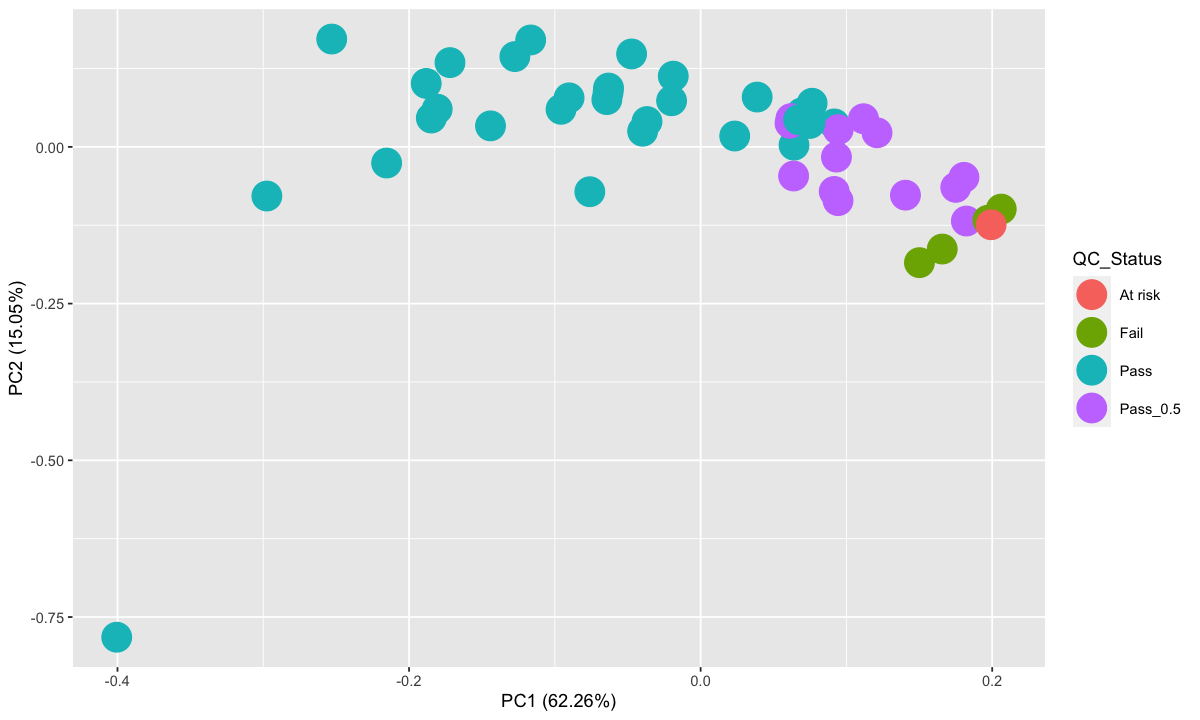

In [221]:
# try regression with sample quality covariate using mrd.status to predict pCR
# controlling for quality score and./or pT/pN stage does not improve the significance of mrd.score or tf.m.f for predicitng Pathologic.Response

source("~/Desktop/puffin/R/helper_functions.R")

# sample quality pca
library(ggfortify)
library(stats)
#names(mrd.qc)
mrd.qc.sel = mrd.qc %>% select(Target.unique.fragment.coverage, Fragment_Size_Bandwidth,
                               Coverage...4000...., Coverage...2000...., total_cfdna_input, library_yield_ug,
                               qubit_ng_ul, total_cfdna_yield) %>%
                      mutate(across(everything(), as.numeric))
 
pca_res <- prcomp(mrd.qc.sel, scale. = TRUE) # 'sdev''rotation''center''scale''x' 
# pca_res #PC1 eq weighted across all metrics except onTargetRate
pca_res
autoplot(pca_res, data = mrd.qc, colour = 'QC_Status',size = 8, title="Sample Quality")

SampleID = mrd.qc[["SampleID"]]
df.qual = data.frame(cbind(pca_res$x, SampleID)) %>% 
                     left_join(mrd.qc %>% select(SampleID, QC_Status), by="SampleID") %>% 
                     mutate("PC1"=as.numeric(PC1)) %>% 
    # arrange(PC1) %>% slice_head(n=23)
    filter(QC_Status!="Fail") # AtRisk, Pass_0.5, Pass, Fail
nrow(df.qual)
#df.qual = mrd.qc %>% select(SampleID, QC_Status) %>% filter(QC_Status=="Pass")

df.reg = summary.f %>% right_join(df.qual, by="SampleID") %>% mutate("mrd.score"=as.numeric(mrd.score)) # passing samples only
reg <- glm(Pathologic.Response ~ tf.m.f + PC1, # + T.Stage + N.Group + ,
           data=df.reg,
           family="binomial")
summary(reg)

reg <- glm(Pathologic.Response ~ mrd.score + PC1, # + T.Stage + N.Group 
           data=df.reg,
           family="binomial")
summary(reg)

#quick_boxplot(df.reg, x = "Pathologic.Response", y="mrd.score", log.axes=FALSE, colors=PR.colors)

## Gene associations

In [354]:
# Load required libraries # with a little help from ChatGPT
#install.packages("BiocManager")
#BiocManager::install("GenomicRanges")
library(GenomicRanges)

all.snv.plasma = read.csv("./mrd_results/WOP00554_PRDC-YALE-TNBC-22001_Variant_short_all_2023-06-06.csv", as.is=T) %>%
                rename("SampleID"="sampleNames") %>%
                filter(altDepth>0,
                      grepl("somatic", VariantType, ignore.case=T),
                      !is.na(SYMBOL))
all.snv.plasma.gr = makeGRangesFromDataFrame(all.snv.plasma, keep.extra.columns = T, strand.field="strand")
length(all.snv.plasma.gr)

all.snv.ffpe = read.table("./PD_probe_design/Yale_MRD_WES_baseline_variants_selected_short.tsv", sep="\t", header=TRUE) %>%
                rename("SampleID"="sampleNames") %>%
                filter(altDepth>0,
                      grepl("somatic", VariantType, ignore.case=T),
                      !is.na(SYMBOL))
all.snv.ffpe.gr <- makeGRangesFromDataFrame(all.snv.ffpe %>% select(-strand), keep.extra.columns = T, ignore.strand=TRUE)
length(all.snv.ffpe.gr)

# Import BED file as a GRanges object
hotspot_panel <- read.delim("~/Desktop/Translational_Science/code_versions/PredicineMRD_V1B_06262023.bed", 
                       header = FALSE, sep = "\t")
hotspot_panel.gr <- GRanges(
  seqnames = as.character(hotspot_panel$V1),
  ranges = IRanges(start = hotspot_panel$V2, end = hotspot_panel$V3),
  metadata = NULL
)
length(hotspot_panel.gr)

# Subset
all.snv.ffpe.gr.mrd <- subsetByOverlaps(all.snv.ffpe.gr, hotspot_panel.gr)
length(all.snv.ffpe.gr.mrd) #86
all.snv.plasma.gr.mrd <- subsetByOverlaps(all.snv.plasma.gr, hotspot_panel.gr)
length(all.snv.plasma.gr.mrd) #37

[1] 1401

[1] 14315

[1] 891

[1] 86

[1] 37

In [355]:
clin.data = clin.data %>% mutate("PatientID"=SubjectID)
all.snv.mrd = rbind.common(data.frame(all.snv.ffpe.gr.mrd) %>% mutate("SampleID"=paste0(PatientID,"..ffpe"), 
                                                                      "SampleType"="ffpe", 
                                                                      "StudyVisit"="Pre-treatment"), 
                           data.frame(all.snv.plasma.gr.mrd) %>% mutate("SampleType"="plasma", "StudyVisit"="Post-treatment"))
nrow(all.snv.mrd) #123

mrd.qc.pass = mrd.qc %>% filter(QC_Status != "Fail")
df_samples = rbind.common(mrd.qc.pass %>% mutate("SampleType"="plasma",
                                                 "StudyVisit"="Post-treatment",
                                                 "SampleID.short"=SampleID),
                          data.frame("SampleID.short"=paste0(unique(clin.data$PatientID), "..ffpe"), 
                                    "SampleType"="ffpe",
                                    "StudyVisit"="Pre-treatment",
                                    "PatientID"=unique(clin.data$PatientID))) 
df_samples.paired = df_samples %>% filter(PatientID %in% mrd.qc.pass$PatientID) %>% distinct()
head(df_samples.paired)

[1] 123

,PatientID,SampleType,StudyVisit,SampleID.short
,<chr>,<chr>,<chr>,<chr>
1,MD0001,plasma,Post-treatment,P228248A01
2,MD0015,plasma,Post-treatment,P228256A01
3,MD0007,plasma,Post-treatment,P228253A01
4,MD0023,plasma,Post-treatment,P228263A01
5,MD0004,plasma,Post-treatment,P228250A01
6,MD0016,plasma,Post-treatment,P228257A01


In [231]:
get_fisher_data <- function (df_all_variants, df_samples){
    print(nrow(df_samples))
    df_variants_sel = df_all_variants %>% filter(SampleID %in% df_samples$SampleID)
    genes = unique(df_variants_sel$SYMBOL)
    #print(genes)
    patients = unique(as.character(df_samples$PatientID))
    fisher_data = list()
    for (patient in patients){
        #print(patient)
        df_patient = df_variants_sel %>% filter(PatientID==patient)
        #print(nrow(df_patient))
        if (nrow(df_patient) == 0){
            patient_data_by_gene_bool = rep(FALSE,length(genes))
        }else{
            patient_data_by_gene_bool = vector()
            for (gene in genes){
                #print(gene)
                df_gene = df_patient %>% filter(SYMBOL==gene)
                #print(nrow(df_gene))
                if (nrow(df_gene) > 0){
                    mutated = TRUE
                }else{
                    mutated = FALSE
                }
                patient_data_by_gene_bool = c(patient_data_by_gene_bool, mutated)
        }}
        stopifnot(length(patient_data_by_gene_bool)==length(genes))
        fisher_data[[patient]] <- patient_data_by_gene_bool
        }
    
    df_fisher_data = do.call(cbind, fisher_data)
    rownames(df_fisher_data) = genes
    return(df_fisher_data)
    }

assoc_test <- function(df_fisher_data, df_clinical){
    # order stage labels by column pids
    response_filter = df_clinical$Pathologic.Response[match(colnames(df_fisher_data), df_clinical$PatientID)]
    response_filter = (response_filter=="pCR")
    print(response_filter)
                           
    ft <- function(row){
      mat = matrix(row, nrow=2, byrow=TRUE)
      #print(mat)
      return(fisher.test(mat)$p.value)}
    
    # STAGE
    df_fisher_test_response = NULL
    if (sum(response_filter) >= 2){
        pcr_mutated = rowSums(df_fisher_data[,response_filter])
        #print(late_mutated)
        pcr_nonmutated = rowSums(!(df_fisher_data[,response_filter]))
        #print(late_nonmutated)
        rd_mutated = rowSums(df_fisher_data[,!(response_filter)])
        #print(early_mutated)
        rd_nonmutated = rowSums(!(df_fisher_data[,!(response_filter)]))
        #print(early_nonmutated)
        df_fisher_test_response = data.frame("rd_nonmutated"=rd_nonmutated, "pcr_nonmutated"=pcr_nonmutated,
                                    "rd_mutated"=rd_mutated, "pcr_mutated"=pcr_mutated)
        #print(head(df_fisher_test_stage))
        df_fisher_test_response$p_value = apply(df_fisher_test_response, 1, ft)
        df_fisher_test_response$signif = ifelse(df_fisher_test_response$p_value <0.05, "*", "")
        print("Pathogenic.Response")
        print(df_fisher_test_response)
        }
    # # add log odds ratios
# df_urine_stage$OR = log(df_urine_stage$late_freq / df_urine_stage$early_freq)
# # reorder the columns
# df_urine_stage2 = df_urine_stage %>% 
#     filter(pct_mutated>(2/11)) %>% 
#     arrange(OR)                     
    return(df_fisher_test_response)
}


In [232]:
# all patients, even unpaired patients
# all.snv.3 = rbind.common(all.snv.plasma, all.snv.ffpe) %>% group_by(SYMBOL) %>% filter(n()>2) %>% ungroup()
# fisher.data.1 = get_fisher_data(all.snv.3, df_samples=df_samples) # includes all snv with altDepth>0
# result = assoc_test(fisher.data.1, df_clinical=clin.data)
result %>% arrange(p_value) %>% slice_head(n=10)

,rd_nonmutated,pcr_nonmutated,rd_mutated,pcr_mutated,p_value,signif
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ELF3,22,18,1,3,0.3346568,
TP53,4,1,19,20,0.3477028,
PTPRD,23,20,0,1,0.4772727,
RHOB,23,20,0,1,0.4772727,
ERBB2,23,20,0,1,0.4772727,
MB21D2,23,20,0,1,0.4772727,
HNF1A,23,20,0,1,0.4772727,
RB1,23,20,0,1,0.4772727,
PTEN,21,21,2,0,0.4894292,


In [233]:
# all hotspot mutations
fisher.data.1 = get_fisher_data(all.snv.mrd, df_samples=df_samples.paired) # includes all hotspot snv with altDepth>0
result = assoc_test(fisher.data.1, df_clinical=clin.data)
result %>% arrange(p_value) %>% slice_head(n=19)

[1] 88
 [1] FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE
[13]  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE
[25]  TRUE FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE
[37]  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE
[1] "Pathogenic.Response"
        rd_nonmutated pcr_nonmutated rd_mutated pcr_mutated   p_value signif
TP53                4              1         19          20 0.3477028       
PTEN               21             21          2           0 0.4894292       
PIK3CA             20             20          3           1 0.6086217       
PTPRD              23             20          0           1 0.4772727       
RHOB               23             20          0           1 0.4772727       
ELF3               22             18          1           3 0.3346568       
ERBB2              23             20          0           1 0.4772727       
MB21D2             23             20          0           1 0.47727

,rd_nonmutated,pcr_nonmutated,rd_mutated,pcr_mutated,p_value,signif
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ELF3,22,18,1,3,0.3346568,
TP53,4,1,19,20,0.3477028,
PTPRD,23,20,0,1,0.4772727,
RHOB,23,20,0,1,0.4772727,
ERBB2,23,20,0,1,0.4772727,
MB21D2,23,20,0,1,0.4772727,
HNF1A,23,20,0,1,0.4772727,
RB1,23,20,0,1,0.4772727,
PTEN,21,21,2,0,0.4894292,


In [128]:
# white list variants
all.snv.mrd.white = all.snv.mrd %>% filter(white.list %in% c("T1","T2B","T0") | VariantID %in% unique(mrd.hotspot.targets$variantid)) %>%
                                    filter(#length(ref)<2, 
                                           #length(alt)<2,
                                           altDepth>0,
                                           #grepl("pathogen", CLIN_SIG, ignore.case=T),
                                           #finalKeep %!in% c("FALSE"),
                                           grepl("somatic",VariantType, ignore.case=T),
                                           #knownVariant=="TRUE",
                                           #excludeMRD=="FALSE",
                                           #!is.na(lowrank.baseline),
                                           #lowrank.baseline!=2,
                                           #!is.na(AF.baseline),
                                           !is.na(SYMBOL))
nrow(all.snv.mrd.white) #91
fisher.data.1 = get_fisher_data(all.snv.mrd.white, df_samples=df_samples.paired)
result = assoc_test(fisher.data.1, df_clinical=clin.data)

[1] 91

[1] 88
 [1] FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE
[13]  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE
[25]  TRUE FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE
[37]  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE
[1] "Pathogenic.Response"
       rd_nonmutated pcr_nonmutated rd_mutated pcr_mutated   p_value signif
TP53               4              2         19          19 0.6663249       
PTEN              21             21          2           0 0.4894292       
PIK3CA            20             20          3           1 0.6086217       
PTPRD             23             20          0           1 0.4772727       
RHOB              23             20          0           1 0.4772727       
ELF3              23             20          0           1 0.4772727       
ERBB2             23             20          0           1 0.4772727       
MB21D2            23             20          0           1 0.4772727       

In [327]:
names(clin.data)

[1] "SampleID"                            
 [2] "ExternalID"                          
 [3] "SubjectID"                           
 [4] "StudyVisit"                          
 [5] "CollectionDate"                      
 [6] "SampleType"                          
 [7] "CancerType"                          
 [8] "CancerStage"                         
 [9] "T.Stage"                             
[10] "N.Stage"                             
[11] "X..of.Tubes"                         
[12] "Volume..mL."                         
[13] "Pathologic.response..pCR.RD."        
[14] "X.any.information.to.help.accession."
[15] "...15"                               
[16] "...16"                               
[17] "Pathologic.Response"                 
[18] "PatientID"

## oncoprint based on tissue and plasma hotspot mutations

[conflicted] Removing existing preference.
[conflicted] Will prefer base::intersect over any other package.


[1] "Setting params and formatting data . . ."
SampleID.short format: none
[1] "selecting snvs . . ."
[1] "selecting cnvs . . ."
[1] "setting colors and symbols . . ."
[1] "set_variant_colors . . ."
[1] "Consequence reduced colors"
   Missense  Truncating    In_Frame      UTR_5p      UTR_3p    Promoter 
"darkgreen"      "blue"   "darkred"     "cyan3"    "maroon"      "pink" 
       Gain        Loss   Multi_hit 
    "black"    "grey52"     "black" 
[1] "create_alter_fun . . ."
[1] "complete."
[1] "Filtering MAF input . . ."
[1] "SNV types present (selecting somatic):"
[1] "Somatic"        "Likely somatic"
[1] "Selected snvs: 124"
[1] "Selected CNVs: 0"
-Validating
--Found  27  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  N.A.
  In_Frame
  NULL
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  substitution
  indel
  NA
-Silent variants: 

All mutation types: pre-treatment_ffpe.Missense,
post-treatment_plasma.Missense, pre-treatment_ffpe.Truncating,
post-treatment_plasma.Multi_hit, post-treatment_plasma.Truncating,
pre-treatment_ffpe.In_Frame, pre-treatment_ffpe.Multi_hit.

Colors are not defined for: post-treatment_plasma.Missense,
post-treatment_plasma.Truncating, post-treatment_plasma.Multi_hit,
pre-treatment_ffpe.Missense, pre-treatment_ffpe.Truncating,
pre-treatment_ffpe.In_Frame, pre-treatment_ffpe.Multi_hit. They won't
be shown in the barplots.



$oncoprint

$legend
[1] NA


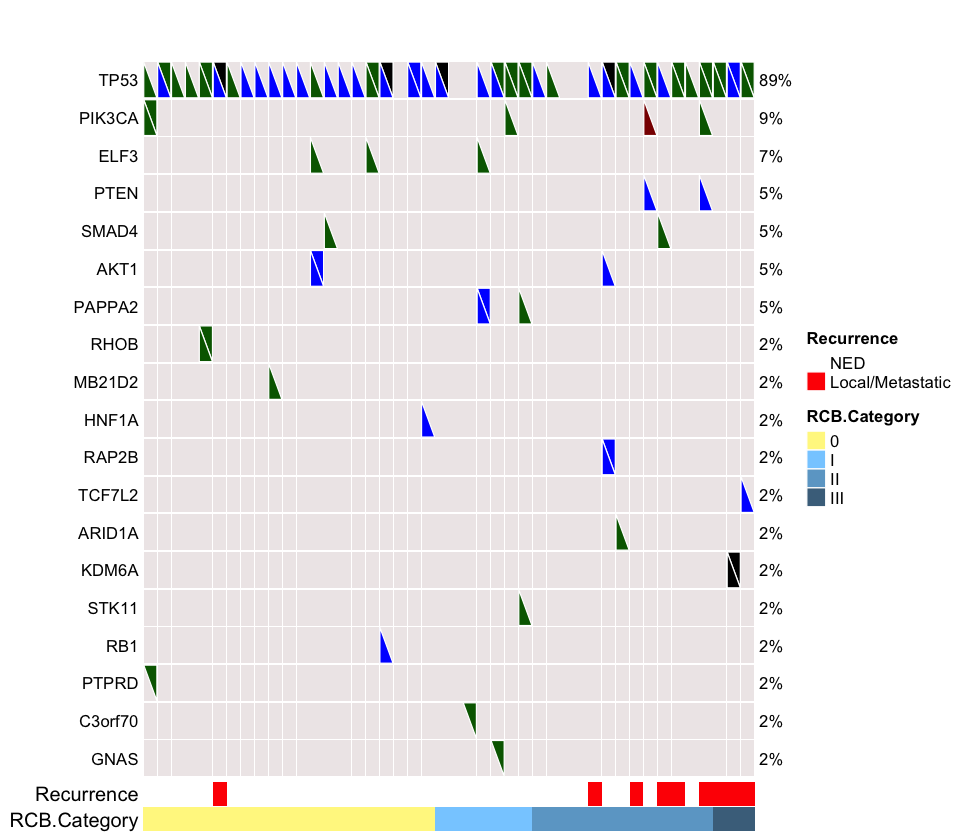

In [331]:
source("~/Desktop/puffin/R/concordance_oncoprint.R")
conflicts_prefer(base::intersect)

# top GENIE genes from mycanergenome
# genes = c("TP53","PIK3CA","ERBB2","GATA3","CDH1","CCND1","FGF19","FGF3","PTEN","MAP3K1","KMT2C",
#           "MTC","ESR1","ARID1A","CDK12","BRIP1","RYR2","USH2A","NF1","KMT2D","AKT1","WHSC1L1","LAMB3","TG","MAP2K4",
#           "COL22A1","RAD21","RECQL4")

clin.data2 = make_names(read_excel("./San_Antonio_BC_2023/Survival and recurrence data _48 cases with ctDNA_Predicine.xlsx",
                        sheet="Survival and recurrence data")) %>% rename("PatientID"="ID") %>% 
                                mutate("Recurrence"=ifelse(Recurrence.status=="NED", "NED", "Local/Metastatic")) %>%
                                mutate(Recurrence=factor(Recurrence, levels=c("NED","Local/Metastatic")),
                                      RCB.Category=factor(as.character(RCB.cat..0..I..II..III.), levels=c("0","I","II","III"), order=TRUE))
                                      
clin.data2 = clin.data %>% left_join(clin.data2 %>% select(PatientID, Recurrence, RCB.Category), by="PatientID") %>%
                            left_join(summary %>% select(PatientID, mrd.status), by="PatientID") #%>%
                            #mutate("ctDNA"=factor(ifelse(mrd.status=="FALSE", "Negative","Positive"), levels=c("Negative","Positive")))
                            #mutate(Tumor.Fraction = ifelse((Tumor.Fraction*100)==0, 0.001, Tumor.Fraction*100))



concordance_oncoprint(snv.data = all.snv.mrd %>% mutate(finalKeep="TRUE"), # this filter might be off for ffpe variants?
                      #cnv.data = cnv.data,
                      sid.format="none",
                      df_samples = df_samples.paired,
                      clin.data = clin.data2 %>% arrange(RCB.Category, T.Stage, N.Stage),
                      concord.barplot = FALSE,
                      ref_sample_type = "Pre-treatment_ffpe", 
                      mrd_sample_type = "Post-treatment_plasma",
                      var.reduc.set = "consequence_reduced",
                      show.clin.data = TRUE,
                      clin.data.cols = c(#"T.Stage", "N.Stage", "Pathologic.Response",
                          "Recurrence","RCB.Category"),
                      clin.annotation.colors = list(#"T.Stage"=c("T1"="indianred1","T2"="indianred3", "T3"="indianred4"),
                                                    #"N.Stage"=c("N0"="steelblue1", "N1"="steelblue2", "N2"="steelblue3", "N3"="steelblue4"),
                                                    #"Pathologic.Response"=c("RD"="dodgerblue","pCR"="khaki1")
                                                    "RCB.Category"=c("0"="khaki1","I"="skyblue1","II"="skyblue3","III"="skyblue4"),
                                                    "Recurrence"=c("NED"="white","Local/Metastatic"="red")#,
                                                    #"ctDNA"=c("Negative"="slategray4","Positive"="plum4")
                                                    ),
                      show.patient.id=FALSE,
                      show.top.n = 25, #ngenes mutated = 19
                      #genes=genes,
                      #make.legend=TRUE,
                      out.file.name="./YALE_PRDC_TNBC_oncoprint_all_genes_07072023"
                      )

In [316]:
# look at recurrence data

clin.data2 = make_names(read_excel("./San_Antonio_BC_2023/Survival and recurrence data _48 cases with ctDNA_Predicine.xlsx",
                        sheet="Survival and recurrence data")) %>% rename("PatientID"="ID") %>%
                            mutate("Recurrence"=ifelse(Recurrence.status=="NED", "NED", "Local/Metastatic"))
names(clin.data2)

[1] "PatientID"                        "Date.of.surgery"                 
 [3] "Recurrence.status"                "Survival.Status"                 
 [5] "Race.Ethnicity"                   "Date.of.first.recurrence"        
 [7] "Date.death"                       "Last.follow.up..as.of.9.19.2021."
 [9] "iDFS"                             "dDFS"                            
[11] "OS"                               "Pathologic.response..pCR.RD."    
[13] "RCB.score"                        "RCB.cat..0..I..II..III."         
[15] "Age.at.On.Study"                  "Stage..anatomical.8th"           
[17] "cT"                               "cN"                              
[19] "ypT"                              "ypN"                             
[21] "Grade"                            "Recurrence"

Complete cases Tumor.Fraction by Recurrence: 37
# A tibble: 2 × 4
  Recurrence       count legend                 color
  <chr>            <chr> <chr>                  <chr>
1 NED              29    NED (n=29)             white
2 Local/Metastatic 8     Local/Metastatic (n=8) red  
NED mean: 0.000855887969937541
Local/Metastatic mean: 0.00414095450701781

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 56, p-value = 0.02811
alternative hypothesis: true location shift is not equal to 0

        Recurrence Tumor.Fraction   label
1              NED     0.02160589 p=0.028
2 Local/Metastatic             NA        


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


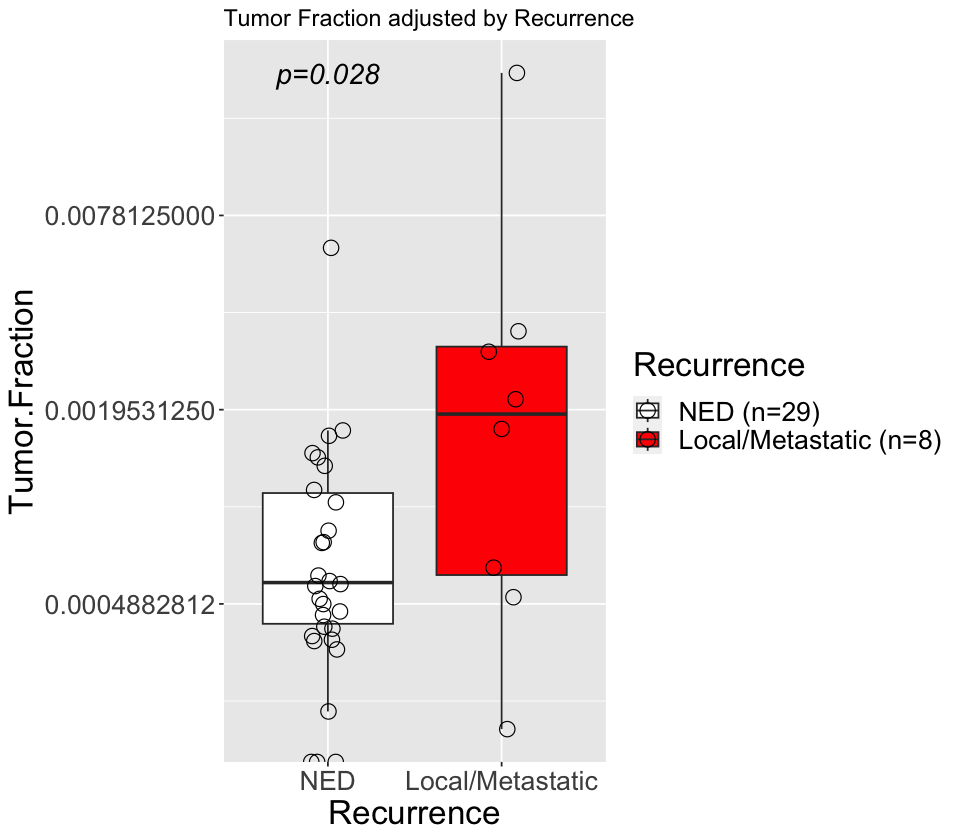

In [291]:
# look at recurrence data

clin.data2 = make_names(read_excel("./San_Antonio_BC_2023/Survival and recurrence data _48 cases with ctDNA_Predicine.xlsx",
                        sheet="Survival and recurrence data")) %>% rename("PatientID"="ID") %>%
                            mutate("Recurrence"=ifelse(Recurrence.status=="NED", "NED", "Local/Metastatic"))
unique(clin.data2$Recurrence)

df = summary %>% left_join(clin.data2 %>% select(PatientID, Recurrence), by="PatientID") %>% 
                                mutate(Recurrence=factor(Recurrence, levels=c("NED","Local/Metastatic")))
colors.recur=c("NED"="white","Local/Metastatic"="red")

source("~/Desktop/puffin/R/helper_functions.R")
quick_boxplot(df, x = "Recurrence", y = "Tumor.Fraction", log.axes=TRUE, replace.log.0 = 0.00001,
              print.p = TRUE, plot.title = "Tumor Fraction adjusted by Recurrence", colors=colors.recur)

[1] "II"  "0"   "III" "I"

Warning message:
“Removed 7 rows containing missing values (`position_stack()`).”


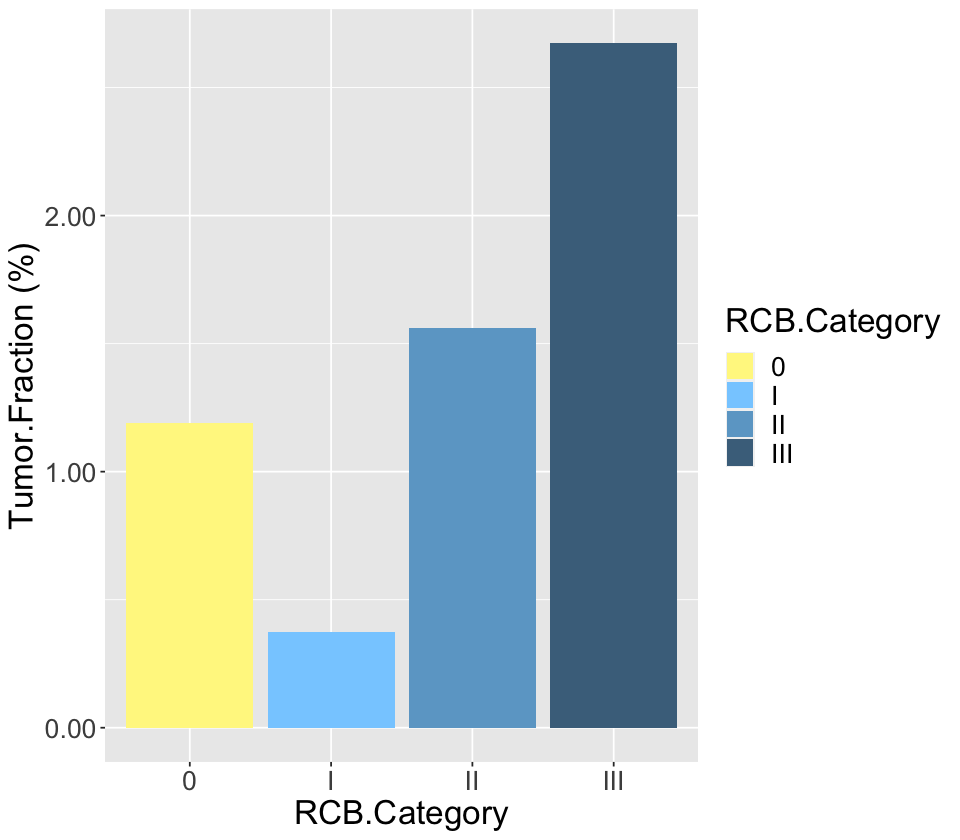

In [314]:
clin.data2 = make_names(read_excel("./San_Antonio_BC_2023/Survival and recurrence data _48 cases with ctDNA_Predicine.xlsx",
                        sheet="Survival and recurrence data")) %>% rename("PatientID"="ID") %>%
                            mutate("Recurrence"=ifelse(Recurrence.status=="NED", "NED", "Local/Metastatic"),
                                  "RCB.Category"=RCB.cat..0..I..II..III.)
unique(clin.data2$RCB.Category)

df = summary %>% left_join(clin.data2 %>% select(PatientID, Recurrence, RCB.Category. Race.Ethnicity, RCB.score), by="PatientID") %>% 
                                mutate(Recurrence=factor(Recurrence, levels=c("NED","Local/Metastatic")),
                                      RCB.Category=factor(as.character(RCB.Category), levels=c("0","I","II","III"), order=TRUE),
                                      Tumor.Fraction = ifelse((Tumor.Fraction*100)==0, 0.001, Tumor.Fraction*100))
colors.rcb=c("khaki1","skyblue1","skyblue3","skyblue4")
names(colors.rcb)=levels(df$RCB.Category)

bar_plot_ <- function(df, x, y, log.axis=FALSE, colors=NULL){
    scaleFUN <- function(x) sprintf("%.2f", x)
    gg <- ggplot(df, aes_string(x=x, y=y, fill=x)) + 
        geom_col() + 
        scale_fill_manual(values=colors) +
        ylab("Tumor.Fraction (%)") + 
        theme(text=element_text(size=20))
    if (log.axis){
        gg <- gg + scale_y_continuous(trans='log2')
    }else{
        gg <- gg + scale_y_continuous(labels=scaleFUN)
    }
    show(gg)
}

bar_plot_(df = df, x = "RCB.Category", y = "Tumor.Fraction", log.axis = FALSE, colors=colors.rcb )

[1] "0"   "II"  "III" "I"

Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”
Warning message in cor.test.default(x = df$RCB.score, y = df$Tumor.Fraction, method = "spearman", :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df$RCB.score and df$Tumor.Fraction
S = 4549, p-value = 0.004106
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.460766 


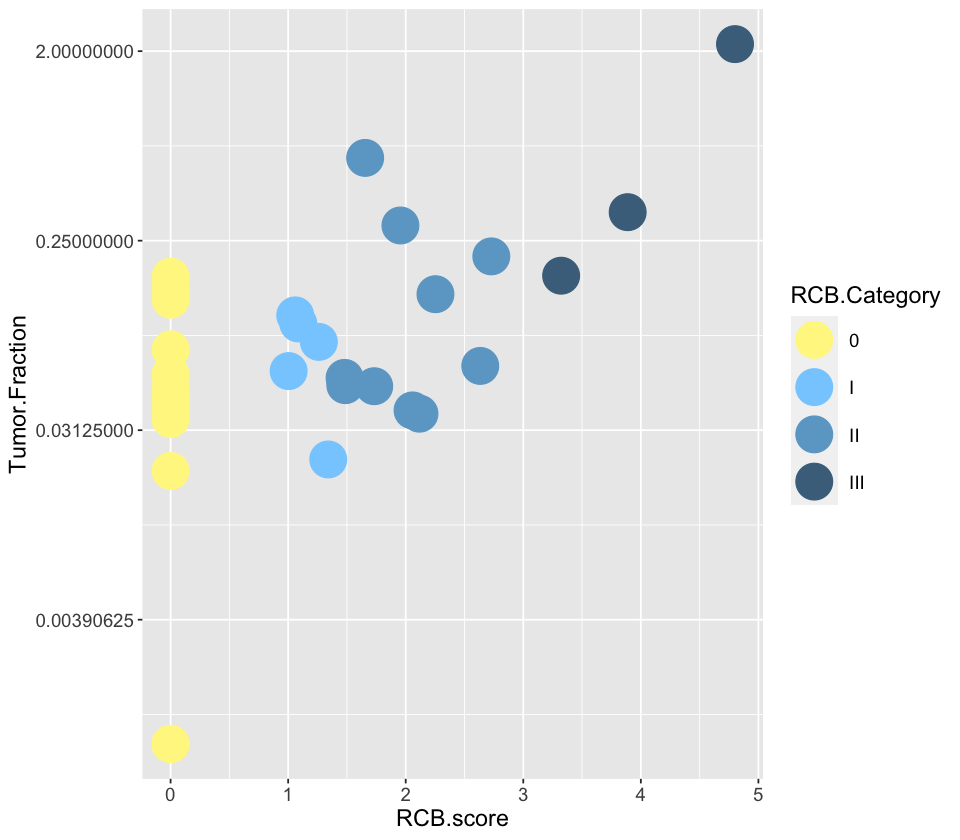

In [350]:
clin.data2 = make_names(read_excel("./San_Antonio_BC_2023/Survival and recurrence data _48 cases with ctDNA_Predicine.xlsx",
                        sheet="Survival and recurrence data")) %>% rename("PatientID"="ID") %>%
                            mutate("Recurrence"=ifelse(Recurrence.status=="NED", "NED", "Local/Metastatic"),
                                  "RCB.Category"=RCB.cat..0..I..II..III.)
unique(clin.data2$RCB.Category)

df = summary %>% left_join(clin.data2 %>% select(PatientID, Recurrence, RCB.Category, Race.Ethnicity, RCB.score), by="PatientID") %>% 
                                mutate(Recurrence=factor(Recurrence, levels=c("NED","Local/Metastatic")),
                                      RCB.Category=factor(as.character(RCB.Category), levels=c("0","I","II","III"), order=TRUE),
                                      Tumor.Fraction = ifelse((Tumor.Fraction*100)==0, 0.001, Tumor.Fraction*100))
colors.rcb=c("khaki1","skyblue1","skyblue3","skyblue4")
names(colors.rcb)=levels(df$RCB.Category)


ggplot(df, aes(x=RCB.score, y=Tumor.Fraction, group=RCB.Category)) +
    geom_point(aes(color=RCB.Category), size=10) +
    scale_color_manual(values=colors.rcb) +
    scale_y_continuous(trans='log2') +
    theme(text=element_text(size=14))

cor.test(x = df$RCB.score, y=df$Tumor.Fraction, method = "spearman",na.action = "omit")

In [380]:
unique(all.snv.mrd.plasma$Variant_Classification)

[1] "Silent"                 "Missense_Mutation"      "Translation_Start_Site"
 [4] "Nonsense_Mutation"      "Intron"                 "IGR"                   
 [7] "In_Frame_Del"           "Frame_Shift_Del"        "Splice_Site"           
[10] "3'UTR"                  "5'Flank"                "Nonstop_Mutation"      
[13] "Frame_Shift_Ins"        "5'UTR"

In [385]:
# annotate novel mrd mutations
all.snv.mrd.plasma = read_excel("./mrd_results/Copy of PRDC-YALE-TNBC-22001_data_20230607.xlsx", sheet="DNA_SNV") %>% 
       mutate(vid=paste(SubjectID, Chromosome, Start_Position, Reference_Allele, Tumor_Seq_Allele, sep=":")) 
nrow(all.snv.mrd.plasma)
all.snv.mrd.ffpe = all.snv.mrd %>% filter(SampleType=="ffpe") %>% mutate(vid=paste(PatientID, VariantID, sep=":"))

novel.vars.1 = (all.snv.mrd.plasma$Variant_Classification %in% c('Silent','Translation_Start_Site','Intron','IGR',
                                                                'In_Frame_Del','Frame_Shift_Del','Splice_Site',
                                                                '3\'UTR','5\'Flank','5\'UTR')) | 
                (grepl("benign", all.snv.mrd.plasma$CLIN_SIG, ignore.case=T))
novel.vars.1[novel.vars.1=="TRUE"] <- NA # set all nonwhitelist to NA, all whitelist to TRUE
table(novel.vars.1, useNA = "always")

novel.vars.2 = (all.snv.mrd.plasma$vid %!in% all.snv.mrd.ffpe$vid) 
table(novel.vars.2, useNA = "always")

novel.vars = ifelse(!is.na(novel.vars.1), novel.vars.2, NA)
table(novel.vars, useNA="always")
#write.csv(all.snv.mrd.plasma, "PRDC-YALE-TNBC-22001_DNA_SNV_annotated_07302023.csv", row.names=F)


[1] 1195

novel.vars.1
FALSE  <NA> 
  868   327 

novel.vars.2
FALSE  TRUE  <NA> 
   22  1173     0 

novel.vars
FALSE  TRUE  <NA> 
   17   851   327 